In [2]:
from math import log, sqrt, pi, exp
from scipy.stats import norm
from datetime import datetime, date, timedelta
from pylab import plt, mpl
import numpy as np
import pandas as pd
from pandas import DataFrame
import csv
import calendar
import re
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
import time
import yfinance as yf
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from arch import arch_model
import pmdarima as pm
import pandas as pd
import numpy as np
from pmdarima import model_selection
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

import pmdarima as pmd
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch

In [3]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)
def adjust(val, length= 6): return str(val).ljust(length)
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, sig=0.05, name=''):
    res = adfuller(series, autolag='AIC')    
    p_value =round(res[1],3)
    adf=round(res[0],3)
    if p_value <= sig:
        print( "Stationary")
        print(adf)
        print(p_value)
    else:
        print( "Non-Stationary")
        print(adf)
        print(p_value)

def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})


In [4]:
def VAR_AIC(data_differenced):
    model = VAR(data_differenced)
    x = model.select_order(maxlags=8)
    return x.summary()

def VAR_Model(min_AIC,data_differenced):
    model = VAR(data_differenced)
    model_fitted = model.fit(min_AIC)
    model_fitted.summary()

    #對fitted model做Durbin-Watson檢測
    

    out = durbin_watson(model_fitted.resid)

    #for col, val in zip(data_differenced.columns, out):
    #    print(adjust(col), ':', round(val, 2))

    
    # Get the lag order
    lag_order = model_fitted.k_ar
    #print(lag_order)  #> 4

    # Input data for forecasting
    forecast_input = data_differenced.values[-lag_order:]
    #print(forecast_input)
    nobs=len(test_data)
    
    # Forecast
    fc = model_fitted.forecast(y=forecast_input, steps=nobs)
    #df_forecast = pd.DataFrame(fc, index=data_differenced.index[-nobs:], columns=data_differenced.columns + '_1d')
    df_forecast = pd.DataFrame(fc, index=data_differenced.index[-nobs:], columns=data_differenced.columns + '_forecast')


    #如果沒有差分都是stationary的話就不用做了
    #df_results = invert_transformation(train_data[["Volume","Adj Close"]], df_forecast, second_diff=False)        
    #df_results.loc[:, ['Volume_forecast', 'Return_forecast']]
    df_results = df_forecast
    
    return out, model_fitted.summary(), nobs, df_results

def ARIMA_Model(y_train,x_train,x_test):
    arima = pmd.auto_arima(y_train,X=x_train, d=2,error_action='ignore', trace=True,
                          suppress_warnings=True, maxiter=500,m=4,stationary=False,test='adf')
    white_noise = acorr_ljungbox(arima.resid(), lags = [10], return_df=True)
    
    
    LM_pvalue = het_arch(arima.resid(), ddof = 4)[1]
    pred=arima.predict(n_periods=VAR_nobs, X=x_test, alpha=0.05)
    return arima.summary(), white_noise,LM_pvalue,pred

import jenkspy
def breakpoint_test(n_breaks,ts):
    y = np.array(ts.tolist())
    breaks = jenkspy.jenks_breaks(y, n_classes=n_breaks-1)
    breaks_jkp = []
    for v in breaks:
        idx = ts.index[ts == v]
        breaks_jkp.append(idx)
    return breaks_jkp

In [5]:
ticker= "tsla"
tsla_data_o = yf.download(ticker, start="2018-01-01", end="2022-12-31")

[*********************100%***********************]  1 of 1 completed


In [6]:
#對原始資料取log
tsla_data_c=np.log(tsla_data_o)
#後減前計算日報酬率(%)
tsla_data_c['Return'] = 100 * (tsla_data_c['Adj Close'].diff(periods=1))
tsla_data_c.dropna(inplace=True)
tsla_data_c

,Open,High,Low,Close,Adj Close,Volume,Return
Date,,,,,,,
2018-01-03,3.063391,3.076544,3.046267,3.051640,3.051640,18.032405,-1.028583
2018-01-04,3.037738,3.055729,3.014489,3.043315,3.043315,18.820761,-0.832453
2018-01-05,3.049652,3.051608,3.034953,3.049526,3.049526,18.047702,0.621042
2018-01-08,3.047692,3.112092,3.046108,3.110280,3.110280,18.811986,6.075470
2018-01-09,3.106558,3.117360,3.083133,3.102162,3.102162,18.490197,-0.811825
...,...,...,...,...,...,...,...
2022-12-23,4.839214,4.856862,4.795956,4.813403,4.813403,18.933443,-1.770668
2022-12-27,4.766438,4.784738,4.689144,4.692265,4.692265,19.156137,-12.113826
2022-12-28,4.703657,4.755915,4.684351,4.724818,4.724818,19.213992,3.255326


In [7]:
#TSLA WSJ Score
csv_file1 = "tesla1.csv"
df1= pd.read_csv(csv_file1)
df1['Date'] = [i.strftime("%Y-%m-%d") for i in pd.to_datetime(df1['Date']) ]
df1['Date']=pd.to_datetime(df1['Date']) 
df1.set_index('Date', inplace=True)
df1

,Negative Score,Neutral Score,Positive Score,Compound Score,count
Date,,,,,
2018-01-03,0.208,3.422,0.370,3.7122,4
2018-01-04,0.198,1.611,0.192,0.7714,2
2018-01-05,0.039,0.853,0.107,0.9300,1
2018-01-09,0.020,0.912,0.069,0.9730,1
2018-01-10,0.033,1.863,0.104,0.9957,2
...,...,...,...,...,...
2022-12-28,0.207,4.458,0.337,3.3137,5
2022-12-29,0.312,3.219,0.469,3.7158,4
2022-12-30,0.289,3.270,0.442,1.5146,4


In [8]:
#合併原始資料（取log後）與Scale_score
tsla_data_cs=tsla_data_c.join(df1)
where_are_NaNs = np.isnan(tsla_data_cs)
tsla_data_cs[where_are_NaNs] = 0
tsla_data_cs

,Open,High,Low,Close,Adj Close,Volume,Return,Negative Score,Neutral Score,Positive Score,Compound Score,count
Date,,,,,,,,,,,,
2018-01-03,3.063391,3.076544,3.046267,3.051640,3.051640,18.032405,-1.028583,0.208,3.422,0.370,3.7122,4.0
2018-01-04,3.037738,3.055729,3.014489,3.043315,3.043315,18.820761,-0.832453,0.198,1.611,0.192,0.7714,2.0
2018-01-05,3.049652,3.051608,3.034953,3.049526,3.049526,18.047702,0.621042,0.039,0.853,0.107,0.9300,1.0
2018-01-08,3.047692,3.112092,3.046108,3.110280,3.110280,18.811986,6.075470,0.000,0.000,0.000,0.0000,0.0
2018-01-09,3.106558,3.117360,3.083133,3.102162,3.102162,18.490197,-0.811825,0.020,0.912,0.069,0.9730,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,4.839214,4.856862,4.795956,4.813403,4.813403,18.933443,-1.770668,0.264,5.240,0.496,5.7588,6.0
2022-12-27,4.766438,4.784738,4.689144,4.692265,4.692265,19.156137,-12.113826,0.138,2.492,0.371,2.9479,3.0
2022-12-28,4.703657,4.755915,4.684351,4.724818,4.724818,19.213992,3.255326,0.207,4.458,0.337,3.3137,5.0


In [9]:
tsla_data_pl=tsla_data_c[["Open", "High", "Low","Close","Adj Close","Volume","Return"]]
tsla_data_pl[["Open", "High", "Low","Close","Adj Close","Volume"]]=tsla_data_pl[["Open", "High", "Low","Close","Adj Close","Volume"]].shift(1)
where_are_NaNs = np.isnan(tsla_data_pl)
tsla_data_pls=tsla_data_pl.join(df1)
where_are_NaNs = np.isnan(tsla_data_pls)
tsla_data_pls[where_are_NaNs] = 0
tsla_data_pls

,Open,High,Low,Close,Adj Close,Volume,Return,Negative Score,Neutral Score,Positive Score,Compound Score,count
Date,,,,,,,,,,,,
2018-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.028583,0.208,3.422,0.370,3.7122,4.0
2018-01-04,3.063391,3.076544,3.046267,3.051640,3.051640,18.032405,-0.832453,0.198,1.611,0.192,0.7714,2.0
2018-01-05,3.037738,3.055729,3.014489,3.043315,3.043315,18.820761,0.621042,0.039,0.853,0.107,0.9300,1.0
2018-01-08,3.049652,3.051608,3.034953,3.049526,3.049526,18.047702,6.075470,0.000,0.000,0.000,0.0000,0.0
2018-01-09,3.047692,3.112092,3.046108,3.110280,3.110280,18.811986,-0.811825,0.020,0.912,0.069,0.9730,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,4.912655,4.917277,4.806150,4.831110,4.831110,19.163048,-1.770668,0.264,5.240,0.496,5.7588,6.0
2022-12-27,4.839214,4.856862,4.795956,4.813403,4.813403,18.933443,-12.113826,0.138,2.492,0.371,2.9479,3.0
2022-12-28,4.766438,4.784738,4.689144,4.692265,4.692265,19.156137,3.255326,0.207,4.458,0.337,3.3137,5.0


In [10]:
#分資料
train_date = tsla_data_cs.index.get_level_values('Date') <= '2022-12-20'
train_data = tsla_data_cs[train_date]
test_data = tsla_data_cs[~train_date]

train_date_pls = tsla_data_pls.index.get_level_values('Date') <= '2022-12-20'
train_data_pls = tsla_data_pls[train_date]
test_data_pls = tsla_data_pls[~train_date]

# 股價模型比較 — 五年資料

In [11]:
import warnings
warnings.filterwarnings('ignore')
VAR_AIC(tsla_data_cs[["Return","Volume"]])

,AIC,BIC,FPE,HQIC
0,1.634,1.642,5.125,1.637
1,0.6402,0.6649,1.897,0.6495
2,0.6209,0.6619*,1.861,0.6363
3,0.6057,0.6631,1.832,0.6273*
4,0.6009,0.6748,1.824,0.6287
5,0.5950,0.6853,1.813,0.6290
6,0.5886,0.6953,1.801,0.6287
7,0.5860*,0.7092,1.797*,0.6323
8,0.5869,0.7264,1.798,0.6393


In [20]:
import warnings
#VAR_DW=VAR_Model(7)[0]
lag=7
VAR_DW_o=VAR_Model(lag,tsla_data_cs[["Return","Volume"]])[0]
#for col, val in zip(data_differenced.columns, VAR_DW_o):
#    print(adjust(col), ':', round(val, 2))
    
VAR_modelfit_o=VAR_Model(lag,tsla_data_cs[["Return","Volume"]])[1]
#print("VAR Model Summary:")
#print(VAR_modelfit_o)

VAR_nobs_o=VAR_Model(lag,tsla_data_cs[["Return","Volume"]])[2]
#print("nobs:",VAR_nobs_o)

VAR_results_o=VAR_Model(lag,tsla_data_cs[["Return","Volume"]])[3]
#VAR_results_o
warnings.filterwarnings('ignore')

In [21]:
VAR_modelfit_o

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 23, Sep, 2024
Time:                     13:26:03
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.708284
Nobs:                     1251.00    HQIC:                  0.631483
Log likelihood:          -3886.24    FPE:                    1.79539
AIC:                     0.585221    Det(Omega_mle):         1.75310
--------------------------------------------------------------------
Results for equation Return
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const            -7.599798         4.726925           -1.608           0.108
L1.Return        -0.027559         0.028437           -0.969           0.332
L1.Volume         0.003114         0.363757            0.009           0.99

In [22]:
VAR_nobs=len(test_data)
ARIMA_vol=ARIMA_Model(train_data_pls['Return'],train_data_pls[["Volume"]],test_data_pls[["Volume"]])
ARIMA_Summary_vol=ARIMA_vol[0]
ARIMA_WN_vol=ARIMA_vol[1]
ARIMA_LM_vol=ARIMA_vol[2]
ARIMA_result_vol=ARIMA_vol[3]

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4]             : AIC=inf, Time=2.89 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=9364.065, Time=0.09 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=8576.294, Time=0.15 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=inf, Time=0.34 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=8574.382, Time=0.06 sec
 ARIMA(1,2,0)(0,0,1)[4]             : AIC=8576.281, Time=0.14 sec
 ARIMA(1,2,0)(1,0,1)[4]             : AIC=8574.415, Time=0.42 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=8177.894, Time=0.10 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=8129.241, Time=0.25 sec
 ARIMA(2,2,0)(2,0,0)[4]             : AIC=8124.577, Time=0.39 sec
 ARIMA(2,2,0)(2,0,1)[4]             : AIC=8125.864, Time=0.71 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=8123.865, Time=0.41 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=8122.812, Time=0.22 sec
 ARIMA(2,2,0)(0,0,2)[4]             : AIC=8123.874, Time=0.39 sec
 ARIMA(2,2,0)(1,0,2)[4]             : AIC=8

In [23]:
ARIMA_vol

(<class 'statsmodels.iolib.summary.Summary'>
 """
                                       SARIMAX Results                                      
 Dep. Variable:                                   y   No. Observations:                 1251
 Model:             SARIMAX(3, 2, 0)x(0, 0, [1], 4)   Log Likelihood               -3948.491
 Date:                             Mon, 23 Sep 2024   AIC                           7908.982
 Time:                                     13:26:24   BIC                           7939.763
 Sample:                                          0   HQIC                          7920.554
                                             - 1251                                         
 Covariance Type:                               opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 Volume        -0.1849      0.266     -0.694  

In [24]:
VAR_nobs=len(test_data)
ARIMA_voladj=ARIMA_Model(train_data_pls['Return'],train_data_pls[["Adj Close","Volume"]],test_data_pls[["Adj Close","Volume"]])
ARIMA_Summary_voladj=ARIMA_voladj[0]
ARIMA_WN_voladj=ARIMA_voladj[1]
ARIMA_LM_voladj=ARIMA_voladj[2]
ARIMA_result_voladj=ARIMA_voladj[3]

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4]             : AIC=inf, Time=1.79 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=8883.073, Time=0.12 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=8273.095, Time=0.43 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=inf, Time=0.71 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=8271.392, Time=0.16 sec
 ARIMA(1,2,0)(0,0,1)[4]             : AIC=8273.065, Time=0.32 sec
 ARIMA(1,2,0)(1,0,1)[4]             : AIC=8272.943, Time=0.55 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=7954.293, Time=0.28 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=7925.320, Time=0.45 sec
 ARIMA(2,2,0)(2,0,0)[4]             : AIC=7924.832, Time=0.82 sec
 ARIMA(2,2,0)(2,0,1)[4]             : AIC=7926.592, Time=1.62 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=7924.594, Time=0.93 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=7922.917, Time=0.42 sec
 ARIMA(2,2,0)(0,0,2)[4]             : AIC=7924.602, Time=0.89 sec
 ARIMA(2,2,0)(1,0,2)[4]             : AIC=7

In [25]:
VAR_nobs=len(test_data)
arima = pmd.auto_arima(train_data['Return'])   
pred=arima.predict(n_periods=VAR_nobs, X=test_data["Return"], alpha=0.05)

(array([19347., 19348., 19349., 19350., 19351., 19352., 19353., 19354.,
        19355., 19356.]),
 [Text(19347.0, 0, '2022-12-21'),
  Text(19348.0, 0, '2022-12-22'),
  Text(19349.0, 0, '2022-12-23'),
  Text(19350.0, 0, '2022-12-24'),
  Text(19351.0, 0, '2022-12-25'),
  Text(19352.0, 0, '2022-12-26'),
  Text(19353.0, 0, '2022-12-27'),
  Text(19354.0, 0, '2022-12-28'),
  Text(19355.0, 0, '2022-12-29'),
  Text(19356.0, 0, '2022-12-30')])

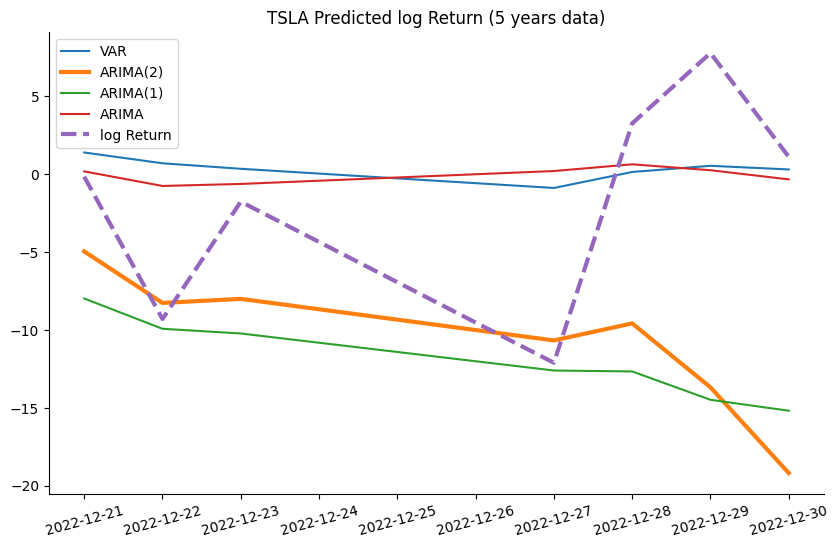

In [26]:
fig,ax = plt.subplots(figsize=(10,6),dpi=100)
ax.spines[['top','right']].set_visible(False)
plt.plot(VAR_results_o["Return_forecast"], label='VAR')
plt.plot(test_data.index,ARIMA_result_voladj, label='ARIMA(2)', linewidth=3)
plt.plot(test_data.index,ARIMA_result_vol, label='ARIMA(1)')
plt.plot(test_data.index,pred, label='ARIMA')
plt.plot(test_data["Return"], label = 'log Return', linewidth=3, linestyle="--")
plt.legend(loc='upper left')
plt.title("TSLA Predicted log Return (5 years data)")
plt.xticks(rotation=15)

ARIMA: Adj Close
mape: 0.1359
me: 15.8672
mae: 15.8672
mpe: 0.1359
rmse: 18.1279
corr: -0.3328
minmax: 0.1151
ARIMA(1): Adj Close
mape: 0.0487
me: 0.5686
mae: 5.8066
mpe: 0.0086
rmse: 7.2454
corr: 0.5808
minmax: 0.0462
ARIMA(2): Adj Close
mape: 0.0611
me: 2.1787
mae: 7.1901
mpe: 0.022
rmse: 8.6648
corr: 0.3327
minmax: 0.0571
VAR: Adj Close
mape: 0.1401
me: 16.4566
mae: 16.4566
mpe: 0.1401
rmse: 18.1764
corr: 0.9309
minmax: 0.1193


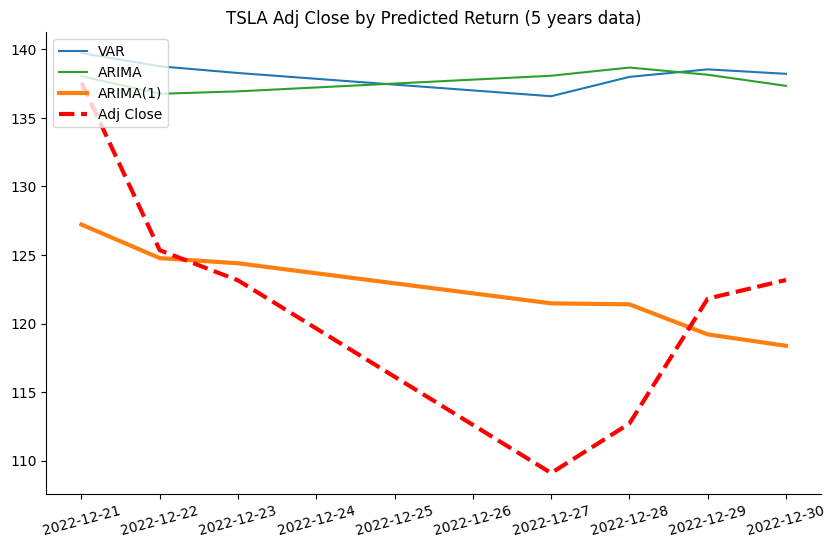

In [28]:
import numpy as np
import matplotlib.pyplot as plt

first_price = tsla_data_o["Adj Close"].iloc[-VAR_nobs-1]  # Adjust indexing with iloc for better compatibility
VAR_nobs = len(test_data)

# Convert Pandas objects to NumPy arrays if necessary
ARIMA_result_rpvol = first_price * np.exp(np.array(ARIMA_result_vol) * 0.01)
ARIMA_result_rpvoladj = first_price * np.exp(np.array(ARIMA_result_voladj) * 0.01)
VAR_result_rp = first_price * np.exp(np.array(VAR_results_o["Return_forecast"]) * 0.01)
ARIMA_pred_rp = first_price * np.exp(np.array(pred) * 0.01)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
ax.spines[['top', 'right']].set_visible(False)

# Plot the results
plt.plot(np.array(test_data.index), VAR_result_rp, label='VAR', color="#1f77b4")
plt.plot(np.array(test_data.index), ARIMA_pred_rp, label='ARIMA', color="#2ca02c")
plt.plot(np.array(test_data.index), ARIMA_result_rpvol, label='ARIMA(1)', linewidth=3, color="#ff7f0e")
plt.plot(np.array(tsla_data_o["Adj Close"].iloc[-VAR_nobs:].index), 
         np.array(tsla_data_o["Adj Close"].iloc[-VAR_nobs:]), 
         label='Adj Close', linewidth=3, linestyle="--", color="red")

# Add legend and title
plt.legend(loc='upper left')
plt.title("TSLA Adj Close by Predicted Return (5 years data)")
plt.xticks(rotation=15)

# ARIMA model accuracy
print('ARIMA: Adj Close')
accuracy_prod = forecast_accuracy(ARIMA_pred_rp, np.array(tsla_data_o["Adj Close"].iloc[-VAR_nobs:]))
for k, v in accuracy_prod.items():
    print(f'{k}: {round(v, 4)}')

print('ARIMA(1): Adj Close')
accuracy_prod = forecast_accuracy(ARIMA_result_rpvol, np.array(tsla_data_o["Adj Close"].iloc[-VAR_nobs:]))
for k, v in accuracy_prod.items():
    print(f'{k}: {round(v, 4)}')

print('ARIMA(2): Adj Close')
accuracy_prod = forecast_accuracy(ARIMA_result_rpvoladj, np.array(tsla_data_o["Adj Close"].iloc[-VAR_nobs:]))
for k, v in accuracy_prod.items():
    print(f'{k}: {round(v, 4)}')

print('VAR: Adj Close')
accuracy_prod = forecast_accuracy(VAR_result_rp, np.array(tsla_data_o["Adj Close"].iloc[-VAR_nobs:]))
for k, v in accuracy_prod.items():
    print(f'{k}: {round(v, 4)}')


# 股價模型加入新聞文字情緒分數比較 — 五年資料

In [29]:
VAR_nobs=len(test_data)
ARIMA_ro=ARIMA_Model(train_data_pls['Return'],train_data_pls[["Volume"]],test_data_pls[["Volume"]])
ARIMA_Summary_ro=ARIMA_ro[0]
ARIMA_WN_ro=ARIMA_ro[1]
ARIMA_LM_ro=ARIMA_ro[2]
ARIMA_result_ro=ARIMA_ro[3]

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4]             : AIC=inf, Time=2.96 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=9364.065, Time=0.10 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=8576.294, Time=0.14 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=inf, Time=0.35 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=8574.382, Time=0.06 sec
 ARIMA(1,2,0)(0,0,1)[4]             : AIC=8576.281, Time=0.15 sec
 ARIMA(1,2,0)(1,0,1)[4]             : AIC=8574.415, Time=0.44 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=8177.894, Time=0.10 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=8129.241, Time=0.27 sec
 ARIMA(2,2,0)(2,0,0)[4]             : AIC=8124.577, Time=0.42 sec
 ARIMA(2,2,0)(2,0,1)[4]             : AIC=8125.864, Time=0.75 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=8123.865, Time=0.42 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=8122.812, Time=0.24 sec
 ARIMA(2,2,0)(0,0,2)[4]             : AIC=8123.874, Time=0.43 sec
 ARIMA(2,2,0)(1,0,2)[4]             : AIC=8

In [30]:
#全部Score跟五年資料


variable=["Volume","Neutral Score","Positive Score","Negative Score","Compound Score"]
ARIMA_rs=ARIMA_Model(train_data_pls['Return'],train_data_pls[variable],test_data_pls[variable])
ARIMA_Summary_rs=ARIMA_rs[0]
ARIMA_WN_rs=ARIMA_rs[1]
ARIMA_LM_rs=ARIMA_rs[2]
ARIMA_result_rs=ARIMA_rs[3]

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4]             : AIC=inf, Time=2.87 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=9361.679, Time=0.24 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=8563.213, Time=1.01 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=inf, Time=0.87 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=8561.299, Time=0.35 sec
 ARIMA(1,2,0)(0,0,1)[4]             : AIC=8563.201, Time=0.85 sec
 ARIMA(1,2,0)(1,0,1)[4]             : AIC=8560.781, Time=1.31 sec
 ARIMA(1,2,0)(2,0,1)[4]             : AIC=8561.236, Time=2.70 sec
 ARIMA(1,2,0)(1,0,2)[4]             : AIC=8561.336, Time=2.83 sec
 ARIMA(1,2,0)(0,0,2)[4]             : AIC=8559.833, Time=1.85 sec
 ARIMA(0,2,0)(0,0,2)[4]             : AIC=9355.040, Time=1.01 sec
 ARIMA(2,2,0)(0,0,2)[4]             : AIC=8114.108, Time=1.22 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=8113.271, Time=0.73 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=8168.227, Time=0.49 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=8

Forecast Accuracy of: Adj Close
mape: 0.0487
me: 0.5686
mae: 5.8066
mpe: 0.0086
rmse: 7.2454
corr: 0.5808
minmax: 0.0462
Forecast Accuracy of: Adj Close with Score
mape: 0.0534
me: -0.4781
mae: 6.4005
mpe: -0.0
rmse: 7.5012
corr: 0.4809
minmax: 0.0512


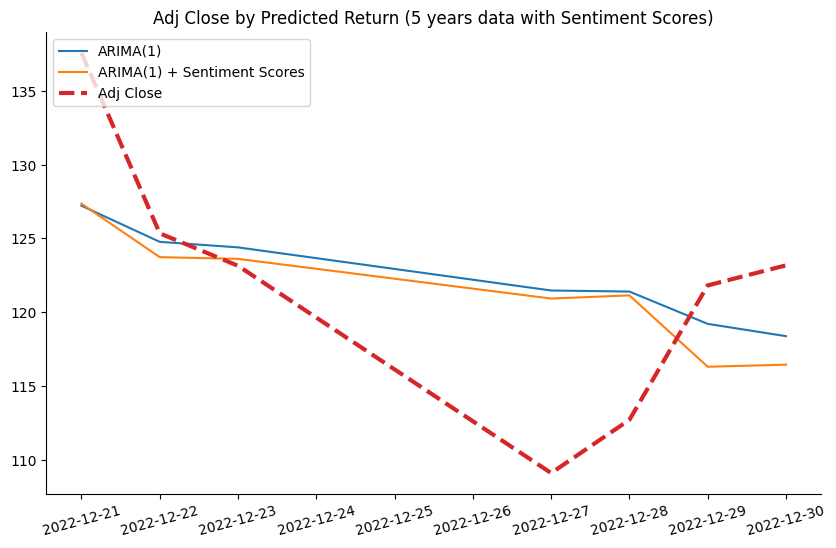

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Getting the first price and converting necessary objects to arrays
first_price = tsla_data_o["Adj Close"].iloc[-VAR_nobs-1]
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

# Convert Pandas objects to NumPy arrays where needed
ARIMA_result_rop = first_price * np.exp(np.array(ARIMA_result_ro) * 0.01)
ARIMA_result_rsp = first_price * np.exp(np.array(ARIMA_result_rs) * 0.01)

# Plot setup
ax.spines[['top', 'right']].set_visible(False)

# Plotting the results
plt.plot(tsla_data_c.index[-VAR_nobs:], ARIMA_result_rop, label='ARIMA(1)')
plt.plot(tsla_data_c.index[-VAR_nobs:], ARIMA_result_rsp, label='ARIMA(1) + Sentiment Scores')

# Convert Pandas Series to NumPy array before plotting
plt.plot(tsla_data_o["Adj Close"].index[-VAR_nobs:], 
         np.array(tsla_data_o["Adj Close"].iloc[-VAR_nobs:]), 
         label='Adj Close', color="#d62728", linewidth=3, linestyle="--")

# Plot legend, title, and adjust x-ticks
plt.legend(loc='upper left')
plt.title("Adj Close by Predicted Return (5 years data with Sentiment Scores)")
plt.xticks(rotation=15)

# Model accuracy evaluation
print('Forecast Accuracy of: Adj Close')
accuracy_prod = forecast_accuracy(ARIMA_result_rop, np.array(tsla_data_o["Adj Close"].iloc[-VAR_nobs:]))
for k, v in accuracy_prod.items():
    print(f'{k}: {round(v, 4)}')

print('Forecast Accuracy of: Adj Close with Score')
accuracy_prod = forecast_accuracy(ARIMA_result_rsp, np.array(tsla_data_o["Adj Close"].iloc[-VAR_nobs:]))
for k, v in accuracy_prod.items():
    print(f'{k}: {round(v, 4)}')


Forecast Accuracy of: Adj Close
mape: 10.591
me: -10.2707
mae: 10.2707
mpe: 4.1796
rmse: 12.8082
corr: -0.3618
minmax: -4.1796
Forecast Accuracy of: Adj Close with Score
mape: 10.8354
me: -11.1473
mae: 11.1473
mpe: 3.8911
rmse: 13.8325
corr: -0.4089
minmax: -3.8911


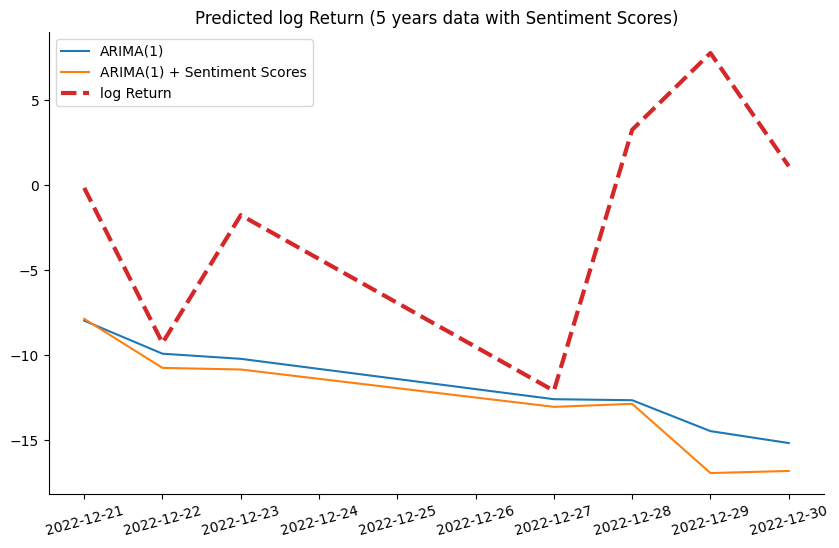

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Assigning the first price (if needed in other calculations)
first_price = tsla_data_o["Adj Close"].iloc[-VAR_nobs-1]

# Create the plot figure and axes
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

# Assuming ARIMA results are already the final predicted returns
ARIMA_result_rop = ARIMA_result_ro
ARIMA_result_rsp = ARIMA_result_rs

# Plot setup
ax.spines[['top', 'right']].set_visible(False)

# Plot the ARIMA results and sentiment-adjusted results
plt.plot(tsla_data_c.index[-VAR_nobs:], ARIMA_result_rop, label='ARIMA(1)')
plt.plot(tsla_data_c.index[-VAR_nobs:], ARIMA_result_rsp, label='ARIMA(1) + Sentiment Scores')

# Convert Pandas Series to NumPy array for 'log Return' plot
plt.plot(tsla_data_cs.index[-VAR_nobs:], np.array(tsla_data_cs["Return"].iloc[-VAR_nobs:]), 
         label='log Return', color="#d62728", linewidth=3, linestyle="--")

# Add legend, title, and adjust x-ticks
plt.legend(loc='upper left')
plt.title("Predicted log Return (5 years data with Sentiment Scores)")
plt.xticks(rotation=15)

# Model accuracy evaluation
print('Forecast Accuracy of: Adj Close')
accuracy_prod = forecast_accuracy(np.array(ARIMA_result_rop), np.array(tsla_data_cs["Return"].iloc[-VAR_nobs:]))
for k, v in accuracy_prod.items():
    print(f'{k}: {round(v, 4)}')

print('Forecast Accuracy of: Adj Close with Score')
accuracy_prod = forecast_accuracy(np.array(ARIMA_result_rsp), np.array(tsla_data_cs["Return"].iloc[-VAR_nobs:]))
for k, v in accuracy_prod.items():
    print(f'{k}: {round(v, 4)}')


# 判斷結構變動

Text(0.5, 1.0, 'Jensky BreakPoint Test (6 breakpoints)')

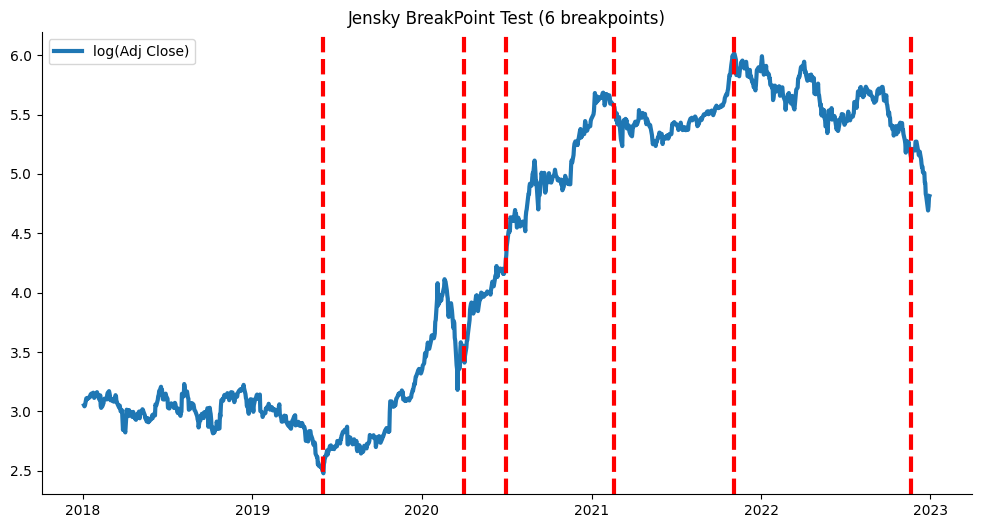

In [54]:
#結構性變動

lag_day=60

breaks_jkp=breakpoint_test(6,tsla_data_c["Adj Close"])
breaks=[]
for i in range(len(breaks_jkp)):
    breaks.append(breaks_jkp[i][0])

breaks=sorted(breaks)
#取Return圖

fig,ax = plt.subplots(figsize=(12,6),dpi=100)
ax.spines[['top','right']].set_visible(False)


plt.plot(tsla_data_c['Adj Close'], label = 'log(Adj Close)',linewidth=3)
#plt.plot(df1["Scale_score"].shift(lag_day), label = 'Scale_score', alpha=0.7)
plt.legend(loc='upper left')
print_legend = True
for i in breaks_jkp:
    if print_legend:
        plt.axvline(i, color='red',linestyle='dashed', label='breaks',linewidth=3)
        print_legend = False
    else:
        plt.axvline(i, color='red',linestyle='dashed',linewidth=3)
plt.title("Jensky BreakPoint Test (6 breakpoints)")


In [55]:
breaks

[Timestamp('2019-06-03 00:00:00'),
 Timestamp('2020-04-02 00:00:00'),
 Timestamp('2020-07-01 00:00:00'),
 Timestamp('2021-02-18 00:00:00'),
 Timestamp('2021-11-04 00:00:00'),
 Timestamp('2022-11-21 00:00:00')]

# 股價模型比較 — 斷點測試

In [56]:
interval=tsla_data_cs.loc[:breaks[0]- timedelta(days=1)]
interval_train=tsla_data_cs.loc[:breaks[0]- timedelta(days=12)]
interval_test=tsla_data_cs.loc[breaks[0]- timedelta(days=11):breaks[0]- timedelta(days=1)]
interval_test

,Open,High,Low,Close,Adj Close,Volume,Return,Negative Score,Neutral Score,Positive Score,Compound Score,count
Date,,,,,,,,,,,,
2019-05-23,2.561559,2.587614,2.518879,2.567459,2.567459,19.802481,1.421898,0.161,1.683,0.156,-0.1140,2.0
2019-05-24,2.589417,2.590167,2.532373,2.542284,2.542284,19.172328,-2.517488,0.058,0.823,0.119,0.9992,1.0
2019-05-28,2.545270,2.564949,2.527594,2.532108,2.532108,18.856956,-1.017594,0.110,0.790,0.100,-0.7817,1.0
2019-05-29,2.523593,2.551474,2.512522,2.538237,2.538237,19.005847,0.612852,0.109,3.381,0.510,3.9864,4.0
2019-05-30,2.532373,2.550798,2.523165,2.529561,2.529561,18.593772,-0.867544,0.000,0.000,0.000,0.0000,0.0
2019-05-31,2.512846,2.538553,2.507429,2.513170,2.513170,18.866011,-1.639121,0.255,3.518,0.228,-0.5216,4.0


In [58]:
#3個斷點取最後一段的資料做預測
#breakpoint_date=tsla_data_c.index.get_level_values('Date') <= breaks_jkp[0][0]
interval=tsla_data_cs.loc[breaks[5]:]
interval_date=interval.index.get_level_values('Date') <= '2022-12-20'
interval_train= interval[interval_date]
interval_test= interval[~interval_date]
interval_test

,Open,High,Low,Close,Adj Close,Volume,Return,Negative Score,Neutral Score,Positive Score,Compound Score,count
Date,,,,,,,,,,,,
2022-12-21,4.936917,4.950602,4.911846,4.924133,4.924133,18.795119,-0.167045,0.116,2.659,0.226,2.6388,3.0
2022-12-22,4.912655,4.917277,4.806150,4.831110,4.831110,19.163048,-9.302312,0.187,1.665,0.147,-0.9923,2.0
2022-12-23,4.839214,4.856862,4.795956,4.813403,4.813403,18.933443,-1.770668,0.264,5.240,0.496,5.7588,6.0
2022-12-27,4.766438,4.784738,4.689144,4.692265,4.692265,19.156137,-12.113826,0.138,2.492,0.371,2.9479,3.0
2022-12-28,4.703657,4.755915,4.684351,4.724818,4.724818,19.213992,3.255326,0.207,4.458,0.337,3.3137,5.0
2022-12-29,4.790736,4.816808,4.766438,4.802545,4.802545,19.217842,7.772640,0.312,3.219,0.469,3.7158,4.0
2022-12-30,4.787075,4.824145,4.785406,4.813647,4.813647,18.876695,1.110216,0.289,3.270,0.442,1.5146,4.0


In [60]:
VAR_AIC(interval[["Return","Volume"]])

,AIC,BIC,FPE,HQIC
0,1.035,1.135,2.816,1.055
1,-0.04637,0.2523,0.9591*,0.01194
2,0.08893,0.5868,1.117,0.1861
3,0.1024,0.7994,1.178,0.2385
4,0.1407,1.037,1.322,0.3156
5,0.05379,1.149,1.387,0.2676
6,-0.3224,0.9721,1.196,-0.06967
7,-0.3008,1.193,1.806,-0.009284
8,-1.510*,0.1826*,1.121,-1.180*


In [61]:
#VAR_DW=VAR_Model(7)[0]
lag=1
VAR_DW_oi=VAR_Model(lag,interval[["Return","Volume"]])[0]
#for col, val in zip(data_differenced.columns, VAR_DW_o):
#    print(adjust(col), ':', round(val, 2))
    
VAR_modelfit_oi=VAR_Model(lag,interval[["Return","Volume"]])[1]
#print("VAR Model Summary:")
#print(VAR_modelfit_o)

VAR_nobs_oi=VAR_Model(lag,interval[["Return","Volume"]])[2]
#print("nobs:",VAR_nobs_o)

VAR_results_oi=VAR_Model(lag,interval[["Return","Volume"]])[3]
#VAR_results_o

In [62]:
VAR_nobs=len(test_data)
ARIMA_voli=ARIMA_Model(interval_train['Return'],interval_train[["Volume"]],interval_test[["Volume"]])
ARIMA_Summary_voli=ARIMA_voli[0]
ARIMA_WN_voli=ARIMA_voli[1]
ARIMA_LM_voli=ARIMA_voli[2]
ARIMA_result_voli=ARIMA_voli[3]


ARIMA_voladji=ARIMA_Model(interval_train['Return'],interval_train[["Adj Close","Volume"]],interval_test[["Adj Close","Volume"]])
ARIMA_Summary_voladji=ARIMA_voladji[0]
ARIMA_WN_voladji=ARIMA_voladji[1]
ARIMA_LM_voladji=ARIMA_voladji[2]
ARIMA_result_voladji=ARIMA_voladji[3]

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4]             : AIC=inf, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=138.314, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=133.266, Time=0.03 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=inf, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=131.627, Time=0.01 sec
 ARIMA(1,2,0)(0,0,1)[4]             : AIC=132.286, Time=0.03 sec
 ARIMA(1,2,0)(1,0,1)[4]             : AIC=inf, Time=0.09 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=133.200, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[4]             : AIC=inf, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[4]             : AIC=inf, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[4]             : AIC=inf, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=133.204, Time=0.01 sec

Best model:  ARIMA(1,2,0)(0,0,0)[4]          
Total fit time: 0.585 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4]             : AIC=inf, Time=0.26 sec
 ARIMA(0,2,0)(0,0,0)

ARIMA(1):Adj Close
0.0759
-8.1806
9.3917
-0.0648
11.5294
0.5145
0.0756
ARIMA(2):Adj Close
0.0645
-7.764
7.764
-0.0645
7.8483
0.9952
0.0645
VAR:Adj Close
0.1257
14.2291
14.7047
0.1223
16.6181
-0.7393
0.108


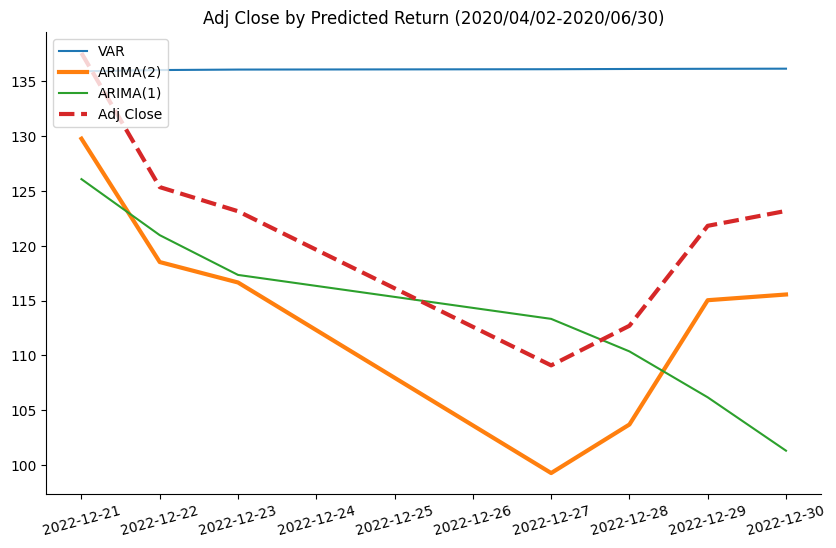

In [63]:
#全部Score跟五年資料
first_pricei=interval_train["Adj Close"][-1]
fig,ax = plt.subplots(figsize=(10,6),dpi=100)
VAR_nobs=len(interval_test)

ARIMA_result_rpvol=np.exp(first_pricei)*np.exp(np.array(ARIMA_result_voli)*0.01)
ARIMA_result_rpvoladj=np.exp(first_pricei)*np.exp(np.array(ARIMA_result_voladji)*0.01)
VAR_result_rp=np.exp(first_pricei)*np.exp(np.array(VAR_results_oi["Return_forecast"])*0.01)

ax.spines[['top','right']].set_visible(False)
plt.plot(interval_test.index,VAR_result_rp, label='VAR')
plt.plot(interval_test.index,ARIMA_result_rpvoladj, label='ARIMA(2)',linewidth=3)
plt.plot(interval_test.index,ARIMA_result_rpvol, label='ARIMA(1)')

plt.plot(interval_test.index,np.exp(np.array(interval_test["Adj Close"])), label = 'Adj Close', linewidth=3, linestyle="--")

plt.legend(loc='upper left')
plt.title("Adj Close by Predicted Return (2020/04/02-2020/06/30)")
plt.xticks(rotation=15)

#arima模型精確度
print('ARIMA(1):Adj Close')
accuracy_prod = forecast_accuracy(ARIMA_result_rpvol,np.exp(np.array(interval_test["Adj Close"])))
for k, v in accuracy_prod.items():
    print(round(v,4))
    
print('ARIMA(2):Adj Close')
accuracy_prod = forecast_accuracy(ARIMA_result_rpvoladj,np.exp(np.array(interval_test["Adj Close"])))
for k, v in accuracy_prod.items():
    print(round(v,4))
    
print('VAR:Adj Close')
accuracy_prod = forecast_accuracy(VAR_result_rp, np.exp(np.array(interval_test["Adj Close"])))
for k, v in accuracy_prod.items():
    print(round(v,4))

# 股價模型加入新聞文字情緒分數比較 — 段點測試(1)

In [64]:
interval=tsla_data_pls.loc[:breaks[0]- timedelta(days=1)]
interval_train=tsla_data_pls.loc[:breaks[0]- timedelta(days=13)]
interval_test=tsla_data_pls.loc[breaks[0]- timedelta(days=12):breaks[0]- timedelta(days=1)]
interval_train

,Open,High,Low,Close,Adj Close,Volume,Return,Negative Score,Neutral Score,Positive Score,Compound Score,count
Date,,,,,,,,,,,,
2018-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.028583,0.208,3.422,0.370,3.7122,4.0
2018-01-04,3.063391,3.076544,3.046267,3.051640,3.051640,18.032405,-0.832453,0.198,1.611,0.192,0.7714,2.0
2018-01-05,3.037738,3.055729,3.014489,3.043315,3.043315,18.820761,0.621042,0.039,0.853,0.107,0.9300,1.0
2018-01-08,3.049652,3.051608,3.034953,3.049526,3.049526,18.047702,6.075470,0.000,0.000,0.000,0.0000,0.0
2018-01-09,3.047692,3.112092,3.046108,3.110280,3.110280,18.811986,-0.811825,0.020,0.912,0.069,0.9730,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-15,2.726981,2.749405,2.721295,2.740022,2.740022,18.504893,-0.155087,0.000,0.000,0.000,0.0000,0.0
2019-05-16,2.727068,2.740582,2.709161,2.738472,2.738472,18.510887,-1.572986,0.260,3.396,0.346,1.5457,4.0
2019-05-17,2.727809,2.734367,2.714695,2.722742,2.722742,18.536235,-7.879160,0.026,0.879,0.095,0.9945,1.0


In [67]:
#3個斷點取最後一段的資料做預測
#breakpoint_date=tsla_data_c.index.get_level_values('Date') <= breaks_jkp[0][0]
interval=tsla_data_psl.loc[breaks[3]:]
interval_date=interval.index.get_level_values('Date') <= '2022-12-20'
interval_train= interval[interval_date]
interval_test= interval[~interval_date]
interval_test

NameError: name 'tsla_data_psl' is not defined

In [101]:
#全部Score跟五年資料
VAR_nobs=len(interval_test)
ARIMA_ro=ARIMA_Model(interval_train[['Return']],interval_train[["Adj Close","Volume"]],interval_test[["Adj Close","Volume"]])
ARIMA_Summary_ro=ARIMA_ro[0]
ARIMA_WN_ro=ARIMA_ro[1]
ARIMA_LM_ro=ARIMA_ro[2]
ARIMA_result_ro=ARIMA_ro[3]

variable=["Adj Close","Volume","Neutral Score","Positive Score","Negative Score","Compound Score"]
ARIMA_rs=ARIMA_Model(interval_train[['Return']],interval_train[variable],interval_test[variable])
ARIMA_Summary_rs=ARIMA_rs[0]
ARIMA_WN_rs=ARIMA_rs[1]
ARIMA_LM_rs=ARIMA_rs[2]
ARIMA_result_rs=ARIMA_rs[3]

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4]             : AIC=inf, Time=1.02 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=2417.494, Time=0.05 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=2219.750, Time=0.11 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=inf, Time=0.12 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=2219.075, Time=0.07 sec
 ARIMA(1,2,0)(0,0,1)[4]             : AIC=2219.694, Time=0.11 sec
 ARIMA(1,2,0)(1,0,1)[4]             : AIC=2219.268, Time=0.16 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=2126.005, Time=0.09 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=2119.505, Time=0.18 sec
 ARIMA(2,2,0)(2,0,0)[4]             : AIC=2121.380, Time=0.29 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=inf, Time=0.31 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=2119.563, Time=0.16 sec
 ARIMA(2,2,0)(2,0,1)[4]             : AIC=inf, Time=0.78 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=2054.486, Time=0.28 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=2073.913, T

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


 ARIMA(2,2,2)(1,0,1)[4]             : AIC=inf, Time=1.54 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=2418.420, Time=0.12 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=2222.342, Time=0.58 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=inf, Time=0.31 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=2221.463, Time=0.30 sec
 ARIMA(1,2,0)(0,0,1)[4]             : AIC=2222.280, Time=0.60 sec
 ARIMA(1,2,0)(1,0,1)[4]             : AIC=2222.760, Time=0.52 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=2128.803, Time=0.37 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=2121.436, Time=0.69 sec
 ARIMA(2,2,0)(2,0,0)[4]             : AIC=2123.342, Time=1.39 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=inf, Time=1.25 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=2121.526, Time=0.65 sec
 ARIMA(2,2,0)(2,0,1)[4]             : AIC=2125.436, Time=1.49 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=2052.377, Time=0.89 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=2072.555, Time=0.55 sec
 ARIMA(3,2,0)(2,0,0)[4]  

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Forecast Accuracy of: Adj Close
0.0474
0.6
0.6
0.0474
0.6421
0.5684
0.045
Forecast Accuracy of: Adj Close with Score
0.0507
0.6417
0.6417
0.0507
0.6702
0.6782
0.048


/var/folders/2x/hsg4y6rn0jv457jmxcnf6s7r0000gp/T/ipykernel_6918/401182582.py:51: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
/var/folders/2x/hsg4y6rn0jv457jmxcnf6s7r0000gp/T/ipykernel_6918/401182582.py:53: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


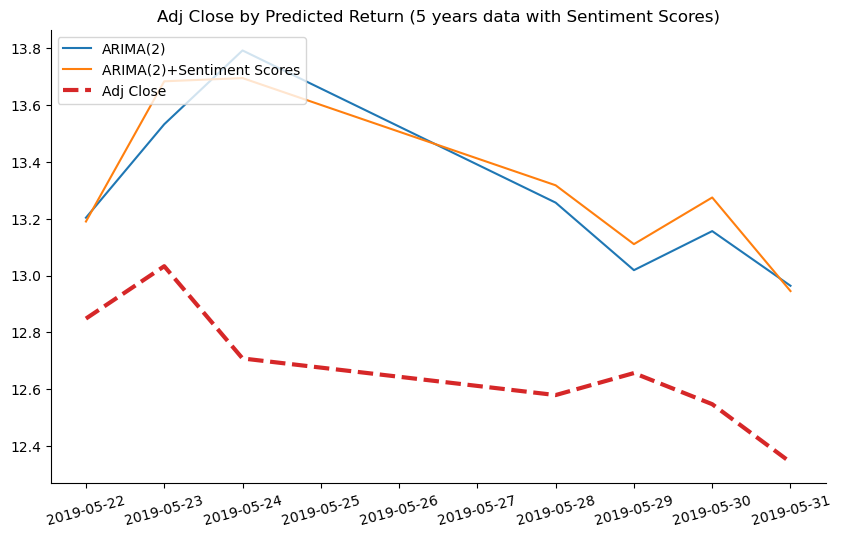

In [102]:
first_price=tsla_data_o["Adj Close"].loc[interval_train.index[-1]]
fig,ax = plt.subplots(figsize=(10,6),dpi=100)
ARIMA_result_rop=first_price*np.exp(np.array(ARIMA_result_ro)*0.01)
ARIMA_result_rsp=first_price*np.exp(np.array(ARIMA_result_rs)*0.01)
ax.spines[['top','right']].set_visible(False)
plt.plot(interval_test.index,ARIMA_result_rop, label='ARIMA(2)')
plt.plot(interval_test.index,ARIMA_result_rsp, label='ARIMA(2)+Sentiment Scores')

plt.plot(tsla_data_o["Adj Close"].loc[interval_test.index], label = 'Adj Close',color="#d62728", linewidth=3, linestyle="--")
plt.legend(loc='upper left')
plt.title("Adj Close by Predicted Return (5 years data with Sentiment Scores)")
plt.xticks(rotation=15)

#arima模型精確度
print('Forecast Accuracy of: Adj Close')
accuracy_prod = forecast_accuracy(ARIMA_result_rop, tsla_data_o["Adj Close"].loc[interval_test.index])
for k, v in accuracy_prod.items():
    print(round(v,4))
    
print('Forecast Accuracy of: Adj Close with Score')
accuracy_prod = forecast_accuracy(ARIMA_result_rsp, tsla_data_o["Adj Close"].loc[interval_test.index])
for k, v in accuracy_prod.items():
    print(round(v,4))

# 股價模型加入新聞文字情緒分數比較 — 段點測試(2)

In [383]:
#3個斷點取最後一段的資料做預測
#breakpoint_date=tsla_data_c.index.get_level_values('Date') <= breaks_jkp[0][0]

interval=tsla_data_pls.loc[breaks[5]:]
interval_date=interval.index.get_level_values('Date') <= "2022-12-20"
interval_train=interval[interval_date]
interval_test=interval[~interval_date]
interval

,Open,High,Low,Close,Adj Close,Volume,Return,Negative Score,Neutral Score,Positive Score,Compound Score,count
Date,,,,,,,,,,,,
2022-11-21,5.220626,5.221382,5.173604,5.194012,5.194012,18.146887,-7.082202,0.240,4.219,0.541,4.9637,5.0
2022-11-22,5.169631,5.174849,5.121222,5.123190,5.123190,18.346848,1.207907,0.177,1.595,0.228,1.9615,2.0
2022-11-23,5.127707,5.141196,5.113132,5.135269,5.135269,18.178001,7.530953,0.104,1.728,0.167,1.1121,2.0
2022-11-25,5.156581,5.212868,5.150397,5.210578,5.210578,18.511770,-0.185760,0.056,0.900,0.044,0.1406,1.0
2022-11-28,5.220680,5.221436,5.196451,5.208721,5.208721,17.740898,0.032805,0.260,2.488,0.251,-0.8282,3.0
2022-11-29,5.192735,5.239098,5.187386,5.209049,5.209049,18.347090,-1.149152,0.350,4.195,0.455,2.4318,5.0
2022-11-30,5.220302,5.227788,5.185988,5.197557,5.197557,18.238644,7.390252,0.185,1.686,0.128,-0.0889,2.0
2022-12-01,5.206366,5.271768,5.196451,5.271460,5.271460,18.508567,0.000000,0.080,1.792,0.128,0.1659,2.0
2022-12-02,5.283610,5.292903,5.256453,5.271460,5.271460,18.198115,0.082146,0.028,1.879,0.092,1.9096,2.0


In [ ]:
#全部Score跟五年資料
VAR_nobs=len(interval_test)
ARIMA_ro=ARIMA_Model(interval_train['Return'],interval_train[["Volume"]],interval_test[["Volume"]])
ARIMA_Summary_ro=ARIMA_ro[0]
ARIMA_WN_ro=ARIMA_ro[1]
ARIMA_LM_ro=ARIMA_ro[2]
ARIMA_result_ro=ARIMA_ro[3]

In [384]:
variable=["Volume","Neutral Score","Positive Score","Negative Score","Compound Score"]
ARIMA_rs=ARIMA_Model(interval_train['Return'],interval_train[variable],interval_test[variable])
ARIMA_Summary_rs=ARIMA_rs[0]
ARIMA_WN_rs=ARIMA_rs[1]
ARIMA_LM_rs=ARIMA_rs[2]
ARIMA_result_rs=ARIMA_rs[3]

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4]             : AIC=inf, Time=0.40 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=142.641, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=137.441, Time=0.11 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=inf, Time=0.13 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=135.457, Time=0.06 sec
 ARIMA(1,2,0)(0,0,1)[4]             : AIC=inf, Time=0.15 sec
 ARIMA(1,2,0)(1,0,1)[4]             : AIC=inf, Time=0.13 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=138.001, Time=0.09 sec
 ARIMA(1,2,1)(0,0,0)[4]             : AIC=inf, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[4]             : AIC=inf, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[4]             : AIC=inf, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=136.759, Time=0.07 sec

Best model:  ARIMA(1,2,0)(0,0,0)[4]          
Total fit time: 1.415 seconds


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Forecast Accuracy of: Adj Close
0.0486
0.1964
5.8126
0.0056
7.2745
0.566
0.0463
Forecast Accuracy of: Adj Close with Score
0.0513
-0.3518
6.1587
-0.0001
6.471
0.6529
0.0497


/var/folders/2x/hsg4y6rn0jv457jmxcnf6s7r0000gp/T/ipykernel_6918/401182582.py:51: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
/var/folders/2x/hsg4y6rn0jv457jmxcnf6s7r0000gp/T/ipykernel_6918/401182582.py:53: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


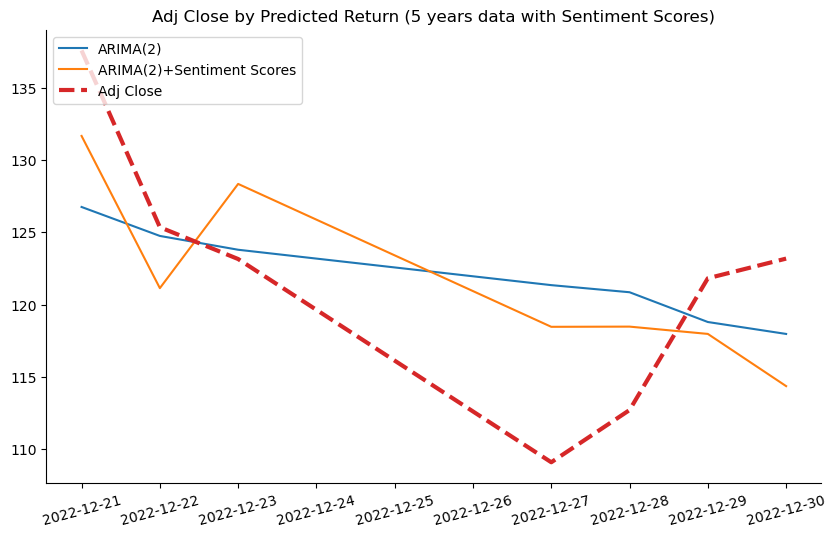

In [385]:
first_price=tsla_data_o["Adj Close"].loc[interval_train.index[-1]]
fig,ax = plt.subplots(figsize=(10,6),dpi=100)
ARIMA_result_rop=first_price*np.exp(np.array(ARIMA_result_ro)*0.01)
ARIMA_result_rsp=first_price*np.exp(np.array(ARIMA_result_rs)*0.01)
ax.spines[['top','right']].set_visible(False)
plt.plot(interval_test.index,ARIMA_result_rop, label='ARIMA(2)')
plt.plot(interval_test.index,ARIMA_result_rsp, label='ARIMA(2)+Sentiment Scores')

plt.plot(tsla_data_o["Adj Close"].loc[interval_test.index], label = 'Adj Close',color="#d62728", linewidth=3, linestyle="--")
plt.legend(loc='upper left')
plt.title("Adj Close by Predicted Return (5 years data with Sentiment Scores)")
plt.xticks(rotation=15)

#arima模型精確度
print('Forecast Accuracy of: Adj Close')
accuracy_prod = forecast_accuracy(ARIMA_result_rop, tsla_data_o["Adj Close"].loc[interval_test.index])
for k, v in accuracy_prod.items():
    print(round(v,4))
    
print('Forecast Accuracy of: Adj Close with Score')
accuracy_prod = forecast_accuracy(ARIMA_result_rsp, tsla_data_o["Adj Close"].loc[interval_test.index])
for k, v in accuracy_prod.items():
    print(round(v,4))

# 股價模型加入新聞文字情緒分數比較 — 段點測試(2) >只有Compound Score

In [401]:
#3個斷點取最後一段的資料做預測
#breakpoint_date=tsla_data_c.index.get_level_values('Date') <= breaks_jkp[0][0]

interval=tsla_data_pls.loc[breaks[5]:]
interval_date=interval.index.get_level_values('Date') <= "2022-12-20"
interval_train=interval[interval_date]
interval_test=interval[~interval_date]
interval_train

,Open,High,Low,Close,Adj Close,Volume,Return,Negative Score,Neutral Score,Positive Score,Compound Score,count
Date,,,,,,,,,,,,
2022-11-21,5.220626,5.221382,5.173604,5.194012,5.194012,18.146887,-7.082202,0.240,4.219,0.541,4.9637,5.0
2022-11-22,5.169631,5.174849,5.121222,5.123190,5.123190,18.346848,1.207907,0.177,1.595,0.228,1.9615,2.0
2022-11-23,5.127707,5.141196,5.113132,5.135269,5.135269,18.178001,7.530953,0.104,1.728,0.167,1.1121,2.0
2022-11-25,5.156581,5.212868,5.150397,5.210578,5.210578,18.511770,-0.185760,0.056,0.900,0.044,0.1406,1.0
2022-11-28,5.220680,5.221436,5.196451,5.208721,5.208721,17.740898,0.032805,0.260,2.488,0.251,-0.8282,3.0
2022-11-29,5.192735,5.239098,5.187386,5.209049,5.209049,18.347090,-1.149152,0.350,4.195,0.455,2.4318,5.0
2022-11-30,5.220302,5.227788,5.185988,5.197557,5.197557,18.238644,7.390252,0.185,1.686,0.128,-0.0889,2.0
2022-12-01,5.206366,5.271768,5.196451,5.271460,5.271460,18.508567,0.000000,0.080,1.792,0.128,0.1659,2.0
2022-12-02,5.283610,5.292903,5.256453,5.271460,5.271460,18.198115,0.082146,0.028,1.879,0.092,1.9096,2.0


In [404]:
interval=tsla_data_pls.loc[:]
interval_date=interval.index.get_level_values('Date') <= "2022-12-20"
interval_train=interval[interval_date]
interval_test=interval[~interval_date]
interval_train

,Open,High,Low,Close,Adj Close,Volume,Return,Negative Score,Neutral Score,Positive Score,Compound Score,count
Date,,,,,,,,,,,,
2018-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.028583,0.208,3.422,0.370,3.7122,4.0
2018-01-04,3.063391,3.076544,3.046267,3.051640,3.051640,18.032405,-0.832453,0.198,1.611,0.192,0.7714,2.0
2018-01-05,3.037738,3.055729,3.014489,3.043315,3.043315,18.820761,0.621042,0.039,0.853,0.107,0.9300,1.0
2018-01-08,3.049652,3.051608,3.034953,3.049526,3.049526,18.047702,6.075470,0.000,0.000,0.000,0.0000,0.0
2018-01-09,3.047692,3.112092,3.046108,3.110280,3.110280,18.811986,-0.811825,0.020,0.912,0.069,0.9730,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-14,5.164043,5.165072,5.055672,5.081094,5.081094,18.985214,-2.612261,0.150,1.682,0.168,-0.0091,2.0
2022-12-15,5.070475,5.085248,5.045423,5.054971,5.054971,18.762015,0.553310,0.105,1.655,0.239,1.8861,2.0
2022-12-16,5.033310,5.080969,5.032266,5.060504,5.060504,18.622270,-4.833681,0.181,2.599,0.220,0.5397,3.0


In [405]:
#全部Score跟五年資料
VAR_nobs=len(interval_test)
ARIMA_ro=ARIMA_Model(interval_train['Return'],interval_train[["Volume"]],interval_test[["Volume"]])
ARIMA_Summary_ro=ARIMA_ro[0]
ARIMA_WN_ro=ARIMA_ro[1]
ARIMA_LM_ro=ARIMA_ro[2]
ARIMA_result_ro=ARIMA_ro[3]

Performing stepwise search to minimize aic


KeyboardInterrupt: 

In [406]:
variable=["Volume","Compound Score"]
ARIMA_rs=ARIMA_Model(interval_train['Return'],interval_train[variable],interval_test[variable])
ARIMA_Summary_rs=ARIMA_rs[0]
ARIMA_WN_rs=ARIMA_rs[1]
ARIMA_LM_rs=ARIMA_rs[2]
ARIMA_result_rs=ARIMA_rs[3]

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4]             : AIC=inf, Time=2.61 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=9366.062, Time=0.18 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=8578.152, Time=0.19 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=inf, Time=0.60 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=8576.231, Time=0.10 sec
 ARIMA(1,2,0)(0,0,1)[4]             : AIC=8578.141, Time=0.18 sec
 ARIMA(1,2,0)(1,0,1)[4]             : AIC=8576.333, Time=0.58 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=8179.318, Time=0.14 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=8130.342, Time=0.36 sec
 ARIMA(2,2,0)(2,0,0)[4]             : AIC=8125.143, Time=0.64 sec
 ARIMA(2,2,0)(2,0,1)[4]             : AIC=8126.536, Time=1.19 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=8124.548, Time=0.55 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=8123.552, Time=0.35 sec
 ARIMA(2,2,0)(0,0,2)[4]             : AIC=8124.528, Time=0.67 sec
 ARIMA(2,2,0)(1,0,2)[4]             : AIC=8

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Forecast Accuracy of: Adj Close
0.0486
0.1964
5.8126
0.0056
7.2745
0.566
0.0463
Forecast Accuracy of: Adj Close with Score
0.0484
0.4699
5.7795
0.0078
7.2223
0.5839
0.046


/var/folders/2x/hsg4y6rn0jv457jmxcnf6s7r0000gp/T/ipykernel_6918/401182582.py:51: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
/var/folders/2x/hsg4y6rn0jv457jmxcnf6s7r0000gp/T/ipykernel_6918/401182582.py:53: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


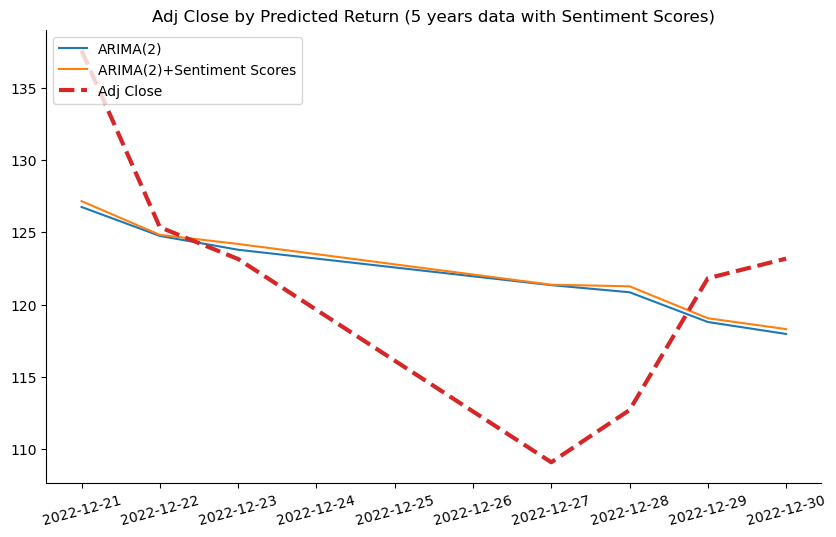

In [407]:
first_price=tsla_data_o["Adj Close"].loc[interval_train.index[-1]]
fig,ax = plt.subplots(figsize=(10,6),dpi=100)
ARIMA_result_rop=first_price*np.exp(np.array(ARIMA_result_ro)*0.01)
ARIMA_result_rsp=first_price*np.exp(np.array(ARIMA_result_rs)*0.01)
ax.spines[['top','right']].set_visible(False)
plt.plot(interval_test.index,ARIMA_result_rop, label='ARIMA(2)')
plt.plot(interval_test.index,ARIMA_result_rsp, label='ARIMA(2)+Sentiment Scores')

plt.plot(tsla_data_o["Adj Close"].loc[interval_test.index], label = 'Adj Close',color="#d62728", linewidth=3, linestyle="--")
plt.legend(loc='upper left')
plt.title("Adj Close by Predicted Return (5 years data with Sentiment Scores)")
plt.xticks(rotation=15)

#arima模型精確度
print('Forecast Accuracy of: Adj Close')
accuracy_prod = forecast_accuracy(ARIMA_result_rop, tsla_data_o["Adj Close"].loc[interval_test.index])
for k, v in accuracy_prod.items():
    print(round(v,4))
    
print('Forecast Accuracy of: Adj Close with Score')
accuracy_prod = forecast_accuracy(ARIMA_result_rsp, tsla_data_o["Adj Close"].loc[interval_test.index])
for k, v in accuracy_prod.items():
    print(round(v,4))

# 股價模型加入新聞文字情緒分數比較 — 滯後測試(lag)

In [408]:
score_var=["Negative Score","Neutral Score","Positive Score","Compound Score","count"]
stock_var=["Open","High","Low","Close","Adj Close","Volume","Return"]
tsla_data_csl=tsla_data_pls[stock_var]
tsla_data_csl[score_var]=tsla_data_pls[score_var].shift(1)
where_are_NaNs = np.isnan(tsla_data_csl)
tsla_data_csl[where_are_NaNs] = 0
tsla_data_csl

/var/folders/2x/hsg4y6rn0jv457jmxcnf6s7r0000gp/T/ipykernel_6918/2500937939.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla_data_csl[score_var]=tsla_data_pls[score_var].shift(1)
/var/folders/2x/hsg4y6rn0jv457jmxcnf6s7r0000gp/T/ipykernel_6918/2500937939.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla_data_csl[score_var]=tsla_data_pls[score_var].shift(1)
/var/folders/2x/hsg4y6rn0jv457jmxcnf6s7r0000gp/T/ipykernel_6918/2500937939.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

,Open,High,Low,Close,Adj Close,Volume,Return,Negative Score,Neutral Score,Positive Score,Compound Score,count
Date,,,,,,,,,,,,
2018-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.028583,0.000,0.000,0.000,0.0000,0.0
2018-01-04,3.063391,3.076544,3.046267,3.051640,3.051640,18.032405,-0.832453,0.208,3.422,0.370,3.7122,4.0
2018-01-05,3.037738,3.055729,3.014489,3.043315,3.043315,18.820761,0.621042,0.198,1.611,0.192,0.7714,2.0
2018-01-08,3.049652,3.051608,3.034953,3.049526,3.049526,18.047702,6.075470,0.039,0.853,0.107,0.9300,1.0
2018-01-09,3.047692,3.112092,3.046108,3.110280,3.110280,18.811986,-0.811825,0.000,0.000,0.000,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,4.912655,4.917277,4.806150,4.831110,4.831110,19.163048,-1.770668,0.187,1.665,0.147,-0.9923,2.0
2022-12-27,4.839214,4.856862,4.795956,4.813403,4.813403,18.933443,-12.113826,0.264,5.240,0.496,5.7588,6.0
2022-12-28,4.766438,4.784738,4.689144,4.692265,4.692265,19.156137,3.255326,0.138,2.492,0.371,2.9479,3.0


### 段點測試(1)— 滯後測試(lag)

In [424]:
interval=tsla_data_cs.loc[:breaks[0]- timedelta(days=1)]
interval_train=tsla_data_cs.loc[:breaks[0]- timedelta(days=12)]
interval_test=tsla_data_cs.loc[breaks[0]- timedelta(days=11):breaks[0]- timedelta(days=1)]
interval_test

,Open,High,Low,Close,Adj Close,Volume,Return,Negative Score,Neutral Score,Positive Score,Compound Score,count
Date,,,,,,,,,,,,
2018-12-13,3.984967,3.996750,3.974988,3.982985,3.982985,17.033826,-0.017701,0.290,4.222,0.488,2.8916,5.0
2018-12-14,3.970311,3.981288,3.960213,3.962440,3.962440,17.408925,-2.054418,0.198,5.102,0.700,5.9310,6.0
2018-12-17,3.957961,3.972535,3.928516,3.937350,3.937350,17.726173,-2.509081,0.113,1.731,0.157,0.9944,2.0
2018-12-18,3.945458,3.969999,3.942048,3.954517,3.954517,17.591485,1.716765,0.222,6.167,0.609,6.8149,7.0
2018-12-19,3.958229,3.985004,3.931267,3.946869,3.946869,17.880495,-0.764848,0.159,2.506,0.335,1.0306,3.0
2018-12-20,3.937691,3.958372,3.919852,3.935329,3.935329,17.798439,-1.153945,0.221,4.414,0.367,3.0703,5.0
2018-12-21,3.943560,3.949001,3.893034,3.903234,3.903234,18.466189,-3.209481,0.217,3.390,0.394,3.9460,4.0


In [ ]:
#3個斷點取最後一段的資料做預測
#breakpoint_date=tsla_data_c.index.get_level_values('Date') <= breaks_jkp[0][0]
interval=tsla_data_cs.loc[breaks[5]:]
interval_date=interval.index.get_level_values('Date') <= '2022-12-20'
interval_train= interval[interval_date]
interval_test= interval[~interval_date]
interval_test

In [ ]:
variable=["Adj Close","Volume","Neutral Score","Positive Score","Negative Score","Compound Score"]
ARIMA_rs=ARIMA_Model(interval_train['Return'],interval_train[variable],interval_test[variable])
ARIMA_Summary_rs=ARIMA_rs[0]
ARIMA_WN_rs=ARIMA_rs[1]
ARIMA_LM_rs=ARIMA_rs[2]
ARIMA_result_rs=ARIMA_rs[3]

In [ ]:
#variable=["Adj Close","Volume","Neutral Score","Positive Score","Negative Score","Compound Score"]
ARIMA_rsl=ARIMA_Model(interval_train_lag['Return'],interval_train_lag[variable],interval_test_lag[variable])
ARIMA_Summary_rsl=ARIMA_rsl[0]
ARIMA_WN_rsl=ARIMA_rsl[1]
ARIMA_LM_rsl=ARIMA_rsl[2]
ARIMA_result_rsl=ARIMA_rsl[3]

In [ ]:
first_price=train_data["Adj Close"][-1]
fig,ax = plt.subplots(figsize=(10,6),dpi=100)
ARIMA_result_rslp=np.exp(first_price)*np.exp(np.array(ARIMA_result_rsl)*0.01)
ARIMA_result_rsp=np.exp(first_price)*np.exp(np.array(ARIMA_result_rs)*0.01)
ax.spines[['top','right']].set_visible(False)
plt.plot(tsla_data_c.index[-VAR_nobs:],ARIMA_result_rslp, label='ARIMA(2)+lag Sentiment Scores')
plt.plot(tsla_data_c.index[-VAR_nobs:],ARIMA_result_rsp, label='ARIMA(2)+Sentiment Scores')

plt.plot(tsla_data_o["Adj Close"][-VAR_nobs:], label = 'Adj Close',color="#d62728", linewidth=3, linestyle="--")
plt.legend(loc='upper left')
plt.title("Adj Close by Predicted Return (5 years data with lag Sentiment Scores)")
plt.xticks(rotation=15)

#arima模型精確度
print('Forecast Accuracy of: Adj Close with lag Score')
accuracy_prod = forecast_accuracy(ARIMA_result_rslp, tsla_data_o["Adj Close"][-VAR_nobs:])
for k, v in accuracy_prod.items():
    print(round(v,4))
    
print('Forecast Accuracy of: Adj Close with Score')
accuracy_prod = forecast_accuracy(ARIMA_result_rsp, tsla_data_o["Adj Close"][-VAR_nobs:])
for k, v in accuracy_prod.items():
    print(round(v,4))

### 段點測試(2)— 滯後測試(lag)

In [449]:
score_var=["Negative Score","Neutral Score","Positive Score","Compound Score","count"]
stock_var=["Open","High","Low","Close","Adj Close","Volume","Return"]
tsla_data_csl=tsla_data_pls[stock_var]
tsla_data_csl[score_var]=tsla_data_pls[score_var].shift(7)
where_are_NaNs = np.isnan(tsla_data_csl)
tsla_data_csl[where_are_NaNs] = 0
tsla_data_csl

/var/folders/2x/hsg4y6rn0jv457jmxcnf6s7r0000gp/T/ipykernel_6918/2908832399.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla_data_csl[score_var]=tsla_data_pls[score_var].shift(7)
/var/folders/2x/hsg4y6rn0jv457jmxcnf6s7r0000gp/T/ipykernel_6918/2908832399.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla_data_csl[score_var]=tsla_data_pls[score_var].shift(7)
/var/folders/2x/hsg4y6rn0jv457jmxcnf6s7r0000gp/T/ipykernel_6918/2908832399.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

,Open,High,Low,Close,Adj Close,Volume,Return,Negative Score,Neutral Score,Positive Score,Compound Score,count
Date,,,,,,,,,,,,
2018-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.028583,0.000,0.000,0.000,0.0000,0.0
2018-01-04,3.063391,3.076544,3.046267,3.051640,3.051640,18.032405,-0.832453,0.000,0.000,0.000,0.0000,0.0
2018-01-05,3.037738,3.055729,3.014489,3.043315,3.043315,18.820761,0.621042,0.000,0.000,0.000,0.0000,0.0
2018-01-08,3.049652,3.051608,3.034953,3.049526,3.049526,18.047702,6.075470,0.000,0.000,0.000,0.0000,0.0
2018-01-09,3.047692,3.112092,3.046108,3.110280,3.110280,18.811986,-0.811825,0.000,0.000,0.000,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,4.912655,4.917277,4.806150,4.831110,4.831110,19.163048,-1.770668,0.150,1.682,0.168,-0.0091,2.0
2022-12-27,4.839214,4.856862,4.795956,4.813403,4.813403,18.933443,-12.113826,0.105,1.655,0.239,1.8861,2.0
2022-12-28,4.766438,4.784738,4.689144,4.692265,4.692265,19.156137,3.255326,0.181,2.599,0.220,0.5397,3.0


In [450]:
#3個斷點取最後一段的資料做預測
#breakpoint_date=tsla_data_c.index.get_level_values('Date') <= breaks_jkp[0][0]

interval=tsla_data_pls.loc[breaks[5]:]
interval_date=interval.index.get_level_values('Date') <= "2022-12-20"
interval_train=interval[interval_date]
interval_test=interval[~interval_date]

interval_lag=tsla_data_csl.loc[breaks[5]:]
#interval_date=interval.index.get_level_values('Date') <= "2022-12-20"
interval_train_lag=interval_lag[interval_date]
interval_test_lag=interval_lag[~interval_date]
interval_train_lag

,Open,High,Low,Close,Adj Close,Volume,Return,Negative Score,Neutral Score,Positive Score,Compound Score,count
Date,,,,,,,,,,,,
2022-11-21,5.220626,5.221382,5.173604,5.194012,5.194012,18.146887,-7.082202,0.063,0.820,0.117,0.9959,1.0
2022-11-22,5.169631,5.174849,5.121222,5.123190,5.123190,18.346848,1.207907,0.437,6.016,0.546,1.1467,7.0
2022-11-23,5.127707,5.141196,5.113132,5.135269,5.135269,18.178001,7.530953,0.180,3.466,0.352,3.8127,4.0
2022-11-25,5.156581,5.212868,5.150397,5.210578,5.210578,18.511770,-0.185760,0.018,0.899,0.084,0.9954,1.0
2022-11-28,5.220680,5.221436,5.196451,5.208721,5.208721,17.740898,0.032805,0.166,4.428,0.404,4.9016,5.0
2022-11-29,5.192735,5.239098,5.187386,5.209049,5.209049,18.347090,-1.149152,0.208,5.184,0.608,5.8934,6.0
2022-11-30,5.220302,5.227788,5.185988,5.197557,5.197557,18.238644,7.390252,0.175,4.333,0.494,4.8244,5.0
2022-12-01,5.206366,5.271768,5.196451,5.271460,5.271460,18.508567,0.000000,0.240,4.219,0.541,4.9637,5.0
2022-12-02,5.283610,5.292903,5.256453,5.271460,5.271460,18.198115,0.082146,0.177,1.595,0.228,1.9615,2.0


In [412]:
variable=["Volume","Neutral Score","Positive Score","Negative Score","Compound Score"]
ARIMA_rs=ARIMA_Model(interval_train['Return'],interval_train[variable],interval_test[variable])
ARIMA_Summary_rs=ARIMA_rs[0]
ARIMA_WN_rs=ARIMA_rs[1]
ARIMA_LM_rs=ARIMA_rs[2]
ARIMA_result_rs=ARIMA_rs[3]

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4]             : AIC=inf, Time=1.03 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=2123.840, Time=0.08 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=1937.345, Time=0.30 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=inf, Time=0.31 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=1939.207, Time=0.10 sec
 ARIMA(1,2,0)(2,0,0)[4]             : AIC=1932.392, Time=0.25 sec
 ARIMA(1,2,0)(2,0,1)[4]             : AIC=1931.894, Time=0.56 sec
 ARIMA(1,2,0)(1,0,1)[4]             : AIC=1931.560, Time=0.38 sec
 ARIMA(1,2,0)(0,0,1)[4]             : AIC=1935.472, Time=0.32 sec
 ARIMA(1,2,0)(1,0,2)[4]             : AIC=1932.090, Time=0.46 sec
 ARIMA(1,2,0)(0,0,2)[4]             : AIC=1930.250, Time=0.36 sec
 ARIMA(0,2,0)(0,0,2)[4]             : AIC=2095.416, Time=0.30 sec
 ARIMA(2,2,0)(0,0,2)[4]             : AIC=1857.994, Time=0.41 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=1859.329, Time=0.22 sec
 ARIMA(2,2,0)(1,0,2)[4]             : AIC=1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [451]:
#variable=["Adj Close","Volume","Neutral Score","Positive Score","Negative Score","Compound Score"]
ARIMA_rsl=ARIMA_Model(interval_train_lag['Return'],interval_train_lag[variable],interval_test_lag[variable])
ARIMA_Summary_rsl=ARIMA_rsl[0]
ARIMA_WN_rsl=ARIMA_rsl[1]
ARIMA_LM_rsl=ARIMA_rsl[2]
ARIMA_result_rsl=ARIMA_rsl[3]

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4]             : AIC=inf, Time=1.36 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=133.366, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=129.229, Time=0.09 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=inf, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=135.298, Time=0.05 sec
 ARIMA(1,2,0)(2,0,0)[4]             : AIC=130.439, Time=0.15 sec
 ARIMA(1,2,0)(1,0,1)[4]             : AIC=inf, Time=0.12 sec
 ARIMA(1,2,0)(0,0,1)[4]             : AIC=inf, Time=0.08 sec
 ARIMA(1,2,0)(2,0,1)[4]             : AIC=inf, Time=0.18 sec
 ARIMA(0,2,0)(1,0,0)[4]             : AIC=130.608, Time=0.05 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=122.496, Time=0.16 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=120.648, Time=0.09 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=122.469, Time=0.14 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=inf, Time=0.16 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=122.512, Time=0.11 sec
 ARIMA

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Forecast Accuracy of: Adj Close with lag Score
0.1363
16.0659
16.0659
0.1363
18.2877
0.3024
0.1158
Forecast Accuracy of: Adj Close with Score
0.0537
0.6592
6.4205
0.0101
8.4405
0.1748
0.0506


/var/folders/2x/hsg4y6rn0jv457jmxcnf6s7r0000gp/T/ipykernel_6918/401182582.py:51: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
/var/folders/2x/hsg4y6rn0jv457jmxcnf6s7r0000gp/T/ipykernel_6918/401182582.py:53: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


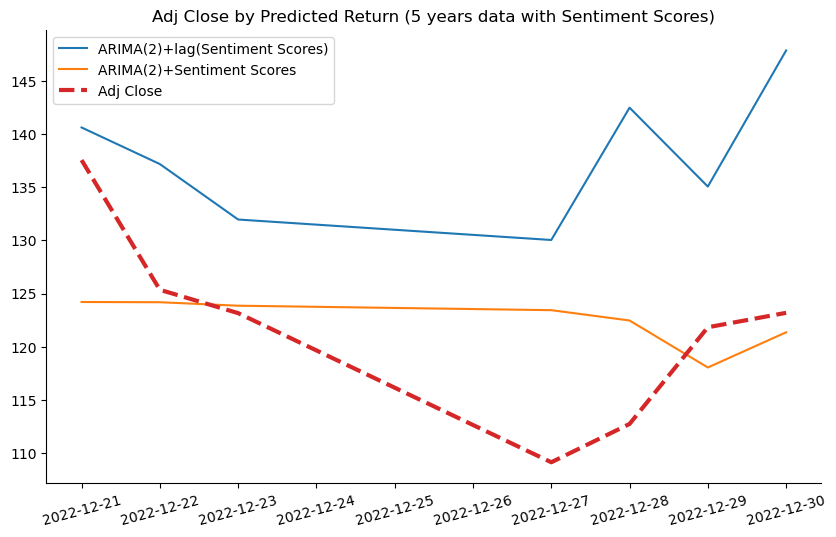

In [452]:
first_price=tsla_data_o["Adj Close"].loc[interval_train.index[-1]]
fig,ax = plt.subplots(figsize=(10,6),dpi=100)
ARIMA_result_rop=first_price*np.exp(np.array(ARIMA_result_rsl)*0.01)
ARIMA_result_rsp=first_price*np.exp(np.array(ARIMA_result_rs)*0.01)
ax.spines[['top','right']].set_visible(False)
plt.plot(interval_test.index,ARIMA_result_rop, label='ARIMA(2)+lag(Sentiment Scores)')
plt.plot(interval_test.index,ARIMA_result_rsp, label='ARIMA(2)+Sentiment Scores')

plt.plot(tsla_data_o["Adj Close"].loc[interval_test.index], label = 'Adj Close',color="#d62728", linewidth=3, linestyle="--")
plt.legend(loc='upper left')
plt.title("Adj Close by Predicted Return (5 years data with Sentiment Scores)")
plt.xticks(rotation=15)

#arima模型精確度
print('Forecast Accuracy of: Adj Close with lag Score')
accuracy_prod = forecast_accuracy(ARIMA_result_rop, tsla_data_o["Adj Close"].loc[interval_test.index])
for k, v in accuracy_prod.items():
    print(round(v,4))
    
print('Forecast Accuracy of: Adj Close with Score')
accuracy_prod = forecast_accuracy(ARIMA_result_rsp, tsla_data_o["Adj Close"].loc[interval_test.index])
for k, v in accuracy_prod.items():
    print(round(v,4))

### 段點測試(2)— 滯後測試(lag) >只有Compound Score

In [482]:
score_var=["Negative Score","Neutral Score","Positive Score","Compound Score","count"]
stock_var=["Open","High","Low","Close","Adj Close","Volume","Return"]
tsla_data_csl=tsla_data_pls[stock_var]
tsla_data_csl[score_var]=tsla_data_pls[score_var].shift(7)
where_are_NaNs = np.isnan(tsla_data_csl)
tsla_data_csl[where_are_NaNs] = 0
tsla_data_csl

/var/folders/2x/hsg4y6rn0jv457jmxcnf6s7r0000gp/T/ipykernel_6918/2908832399.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla_data_csl[score_var]=tsla_data_pls[score_var].shift(7)
/var/folders/2x/hsg4y6rn0jv457jmxcnf6s7r0000gp/T/ipykernel_6918/2908832399.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla_data_csl[score_var]=tsla_data_pls[score_var].shift(7)
/var/folders/2x/hsg4y6rn0jv457jmxcnf6s7r0000gp/T/ipykernel_6918/2908832399.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

,Open,High,Low,Close,Adj Close,Volume,Return,Negative Score,Neutral Score,Positive Score,Compound Score,count
Date,,,,,,,,,,,,
2018-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.028583,0.000,0.000,0.000,0.0000,0.0
2018-01-04,3.063391,3.076544,3.046267,3.051640,3.051640,18.032405,-0.832453,0.000,0.000,0.000,0.0000,0.0
2018-01-05,3.037738,3.055729,3.014489,3.043315,3.043315,18.820761,0.621042,0.000,0.000,0.000,0.0000,0.0
2018-01-08,3.049652,3.051608,3.034953,3.049526,3.049526,18.047702,6.075470,0.000,0.000,0.000,0.0000,0.0
2018-01-09,3.047692,3.112092,3.046108,3.110280,3.110280,18.811986,-0.811825,0.000,0.000,0.000,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,4.912655,4.917277,4.806150,4.831110,4.831110,19.163048,-1.770668,0.150,1.682,0.168,-0.0091,2.0
2022-12-27,4.839214,4.856862,4.795956,4.813403,4.813403,18.933443,-12.113826,0.105,1.655,0.239,1.8861,2.0
2022-12-28,4.766438,4.784738,4.689144,4.692265,4.692265,19.156137,3.255326,0.181,2.599,0.220,0.5397,3.0


In [483]:
#3個斷點取最後一段的資料做預測
#breakpoint_date=tsla_data_c.index.get_level_values('Date') <= breaks_jkp[0][0]

interval=tsla_data_pls.loc[breaks[4]:]
interval_date=interval.index.get_level_values('Date') <= "2022-12-20"
interval_train=interval[interval_date]
interval_test=interval[~interval_date]
interval_train

interval_lag=tsla_data_csl.loc[breaks[4]:]
#interval_date=interval.index.get_level_values('Date') <= "2022-12-20"
interval_train_lag=interval_lag[interval_date]
interval_test_lag=interval_lag[~interval_date]
interval_train_lag

,Open,High,Low,Close,Adj Close,Volume,Return,Negative Score,Neutral Score,Positive Score,Compound Score,count
Date,,,,,,,,,,,,
2021-11-04,5.972392,6.004208,5.951181,6.002948,6.002948,18.458800,1.313565,0.338,6.704,0.958,7.6116,8.0
2021-11-05,6.019736,6.027065,6.005532,6.016084,6.016084,18.148770,-0.637847,0.174,3.467,0.359,3.9393,4.0
2021-11-08,6.014530,6.024150,5.998109,6.009706,6.009706,17.988149,-4.961125,0.167,4.394,0.440,4.7663,5.0
2021-11-09,5.948722,5.988961,5.934012,5.960094,5.960094,18.424046,-12.772319,0.369,5.919,0.711,4.9645,7.0
2021-11-10,5.969219,5.969986,5.820597,5.832371,5.832371,18.993452,4.251284,0.037,1.808,0.155,1.9671,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-14,5.164043,5.165072,5.055672,5.081094,5.081094,18.985214,-2.612261,0.154,1.631,0.214,1.8725,2.0
2022-12-15,5.070475,5.085248,5.045423,5.054971,5.054971,18.762015,0.553310,0.029,0.894,0.078,0.9922,1.0
2022-12-16,5.033310,5.080969,5.032266,5.060504,5.060504,18.622270,-4.833681,0.000,0.000,0.000,0.0000,0.0


In [246]:
variable=["Volume","Compound Score"]
ARIMA_rs=ARIMA_Model(interval_train['Return'],interval_train[variable],interval_test[variable])
ARIMA_Summary_rs=ARIMA_rs[0]
ARIMA_WN_rs=ARIMA_rs[1]
ARIMA_LM_rs=ARIMA_rs[2]
ARIMA_result_rs=ARIMA_rs[3]

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4]             : AIC=inf, Time=2.28 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=9361.039, Time=0.18 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=8575.709, Time=0.20 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=inf, Time=0.76 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=8573.874, Time=0.11 sec
 ARIMA(1,2,0)(0,0,1)[4]             : AIC=8575.685, Time=0.24 sec
 ARIMA(1,2,0)(1,0,1)[4]             : AIC=8573.579, Time=0.62 sec
 ARIMA(1,2,0)(2,0,1)[4]             : AIC=8573.893, Time=0.76 sec
 ARIMA(1,2,0)(1,0,2)[4]             : AIC=8574.013, Time=0.66 sec
 ARIMA(1,2,0)(0,0,2)[4]             : AIC=8572.690, Time=0.51 sec
 ARIMA(0,2,0)(0,0,2)[4]             : AIC=9354.707, Time=0.49 sec
 ARIMA(2,2,0)(0,0,2)[4]             : AIC=8121.426, Time=0.62 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=8120.583, Time=0.34 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=8174.051, Time=0.17 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=8

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [484]:
#variable=["Adj Close","Volume","Neutral Score","Positive Score","Negative Score","Compound Score"]
ARIMA_rsl=ARIMA_Model(interval_train_lag['Return'],interval_train_lag[variable],interval_test_lag[variable])
ARIMA_Summary_rsl=ARIMA_rsl[0]
ARIMA_WN_rsl=ARIMA_rsl[1]
ARIMA_LM_rsl=ARIMA_rsl[2]
ARIMA_result_rsl=ARIMA_rsl[3]

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4]             : AIC=inf, Time=1.90 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=2128.695, Time=0.09 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=1942.099, Time=0.32 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=inf, Time=0.29 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=1941.826, Time=0.20 sec
 ARIMA(1,2,0)(0,0,1)[4]             : AIC=1941.353, Time=0.34 sec
 ARIMA(1,2,0)(1,0,1)[4]             : AIC=1938.795, Time=0.43 sec
 ARIMA(1,2,0)(2,0,1)[4]             : AIC=1938.035, Time=0.80 sec
 ARIMA(1,2,0)(2,0,0)[4]             : AIC=1938.425, Time=0.58 sec
 ARIMA(1,2,0)(2,0,2)[4]             : AIC=1936.613, Time=1.70 sec
 ARIMA(1,2,0)(1,0,2)[4]             : AIC=1938.537, Time=0.81 sec
 ARIMA(0,2,0)(2,0,2)[4]             : AIC=2103.298, Time=0.91 sec
 ARIMA(2,2,0)(2,0,2)[4]             : AIC=1857.026, Time=1.64 sec
 ARIMA(2,2,0)(1,0,2)[4]             : AIC=1865.106, Time=1.68 sec
 ARIMA(2,2,0)(2,0,1)[4]             : AIC=1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Forecast Accuracy of: Adj Close with lag Score
0.0615
4.183
7.2672
0.0391
9.1336
0.4374
0.0567
Forecast Accuracy of: Adj Close with Score
0.0537
0.6592
6.4205
0.0101
8.4405
0.1748
0.0506


/var/folders/2x/hsg4y6rn0jv457jmxcnf6s7r0000gp/T/ipykernel_6918/401182582.py:51: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
/var/folders/2x/hsg4y6rn0jv457jmxcnf6s7r0000gp/T/ipykernel_6918/401182582.py:53: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


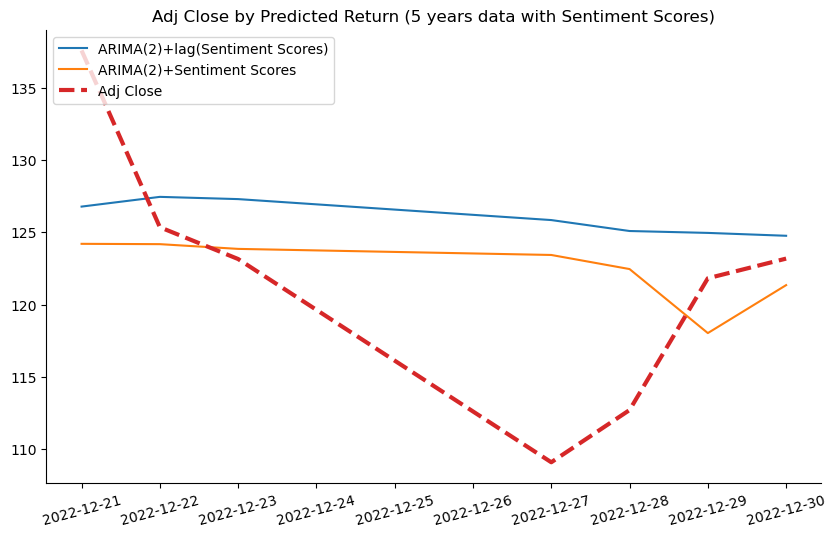

In [485]:
first_price=tsla_data_o["Adj Close"].loc[interval_train.index[-1]]
fig,ax = plt.subplots(figsize=(10,6),dpi=100)
ARIMA_result_rop=first_price*np.exp(np.array(ARIMA_result_rsl)*0.01)
ARIMA_result_rsp=first_price*np.exp(np.array(ARIMA_result_rs)*0.01)
ax.spines[['top','right']].set_visible(False)
plt.plot(interval_test.index,ARIMA_result_rop, label='ARIMA(2)+lag(Sentiment Scores)')
plt.plot(interval_test.index,ARIMA_result_rsp, label='ARIMA(2)+Sentiment Scores')

plt.plot(tsla_data_o["Adj Close"].loc[interval_test.index], label = 'Adj Close',color="#d62728", linewidth=3, linestyle="--")
plt.legend(loc='upper left')
plt.title("Adj Close by Predicted Return (5 years data with Sentiment Scores)")
plt.xticks(rotation=15)

#arima模型精確度
print('Forecast Accuracy of: Adj Close with lag Score')
accuracy_prod = forecast_accuracy(ARIMA_result_rop, tsla_data_o["Adj Close"].loc[interval_test.index])
for k, v in accuracy_prod.items():
    print(round(v,4))
    
print('Forecast Accuracy of: Adj Close with Score')
accuracy_prod = forecast_accuracy(ARIMA_result_rsp, tsla_data_o["Adj Close"].loc[interval_test.index])
for k, v in accuracy_prod.items():
    print(round(v,4))

# Hybrid 模型建構

In [486]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor as DTR

### 斷點測試(1)

In [372]:
interval=tsla_data_cs.loc[breaks[7]:breaks[8]- timedelta(days=1)]
interval_train=tsla_data_cs.loc[breaks[7]:breaks[8]- timedelta(days=11)]
interval_test=tsla_data_cs.loc[breaks[8]- timedelta(days=10):breaks[8]- timedelta(days=1)]
interval_test

,Open,High,Low,Close,Adj Close,Volume,Return,Negative Score,Neutral Score,Positive Score,Compound Score,count
Date,,,,,,,,,,,,
2022-06-21,4.690701,4.722860,4.687671,4.714419,4.714419,17.674470,4.025005,0.247,5.282,0.471,5.5815,6.0
2022-06-22,4.705527,4.730449,4.703952,4.713913,4.713913,17.242181,-0.050662,0.177,3.509,0.315,2.0838,4.0
2022-06-23,4.720564,4.725106,4.705020,4.720657,4.720657,17.160561,0.674472,0.196,5.366,0.437,5.1867,6.0
2022-06-24,4.727344,4.771354,4.726967,4.770473,4.770473,17.533075,4.981550,0.125,2.714,0.162,1.3044,3.0
2022-06-27,4.772996,4.775584,4.746492,4.752154,4.752154,17.410629,-1.831888,0.034,0.872,0.094,0.9973,1.0
2022-06-28,4.751886,4.764816,4.717141,4.718566,4.718566,17.393235,-3.358802,0.283,6.168,0.551,4.9215,7.0
2022-06-29,4.714491,4.728807,4.708381,4.715830,4.715830,17.022961,-0.273570,0.139,3.535,0.326,2.0633,4.0
2022-06-30,4.700480,4.708521,4.670490,4.691008,4.691008,17.580656,-2.482178,0.200,4.396,0.403,4.5951,5.0


### 斷點測試(2)

In [525]:
#3個斷點取最後一段的資料做預測
#breakpoint_date=tsla_data_c.index.get_level_values('Date') <= breaks_jkp[0][0]

interval=tsla_data_pls.loc[breaks[2]:]
interval_date=interval.index.get_level_values('Date') <= "2022-10-01"
interval_train=interval[interval_date]
interval_test=interval[~interval_date]
interval

,Open,High,Low,Close,Adj Close,Volume,Return,Negative Score,Neutral Score,Positive Score,Compound Score,count
Date,,,,,,,,,,,,
2020-07-01,4.206184,4.283761,4.203428,4.276490,4.276490,19.351968,3.621312,0.016,0.921,0.063,0.9788,1.0
2020-07-02,4.279440,4.326628,4.277129,4.312703,4.312703,19.113345,7.651404,0.117,2.611,0.272,2.9726,3.0
2020-07-06,4.399768,4.405092,4.369954,4.389217,4.389217,19.371379,12.645108,0.080,0.761,0.158,0.9995,1.0
2020-07-07,4.443976,4.520186,4.435599,4.515668,4.515668,19.547390,1.323966,0.150,4.455,0.393,3.5184,5.0
2020-07-08,4.539750,4.557030,4.489916,4.528908,4.528908,19.591135,-1.740408,0.000,0.000,0.000,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,4.912655,4.917277,4.806150,4.831110,4.831110,19.163048,-1.770668,0.264,5.240,0.496,5.7588,6.0
2022-12-27,4.839214,4.856862,4.795956,4.813403,4.813403,18.933443,-12.113826,0.138,2.492,0.371,2.9479,3.0
2022-12-28,4.766438,4.784738,4.689144,4.692265,4.692265,19.156137,3.255326,0.207,4.458,0.337,3.3137,5.0


### 滯後測試

In [504]:
score_var=["Negative Score","Neutral Score","Positive Score","Compound Score","count"]
stock_var=["Open","High","Low","Close","Adj Close","Volume","Return"]
tsla_data_csl=tsla_data_cs[stock_var]
tsla_data_csl[score_var]=tsla_data_cs[score_var].shift(3)
where_are_NaNs = np.isnan(tsla_data_csl)
tsla_data_csl[where_are_NaNs] = 0
tsla_data_csl

/var/folders/2x/hsg4y6rn0jv457jmxcnf6s7r0000gp/T/ipykernel_6918/2687843743.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla_data_csl[score_var]=tsla_data_cs[score_var].shift(3)
/var/folders/2x/hsg4y6rn0jv457jmxcnf6s7r0000gp/T/ipykernel_6918/2687843743.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla_data_csl[score_var]=tsla_data_cs[score_var].shift(3)
/var/folders/2x/hsg4y6rn0jv457jmxcnf6s7r0000gp/T/ipykernel_6918/2687843743.py:4: SettingWithCopyWarning: 
A value is trying to be set on a cop

,Open,High,Low,Close,Adj Close,Volume,Return,Negative Score,Neutral Score,Positive Score,Compound Score,count
Date,,,,,,,,,,,,
2018-01-03,3.063391,3.076544,3.046267,3.051640,3.051640,18.032405,-1.028583,0.000,0.000,0.000,0.0000,0.0
2018-01-04,3.037738,3.055729,3.014489,3.043315,3.043315,18.820761,-0.832453,0.000,0.000,0.000,0.0000,0.0
2018-01-05,3.049652,3.051608,3.034953,3.049526,3.049526,18.047702,0.621042,0.000,0.000,0.000,0.0000,0.0
2018-01-08,3.047692,3.112092,3.046108,3.110280,3.110280,18.811986,6.075470,0.208,3.422,0.370,3.7122,4.0
2018-01-09,3.106558,3.117360,3.083133,3.102162,3.102162,18.490197,-0.811825,0.198,1.611,0.192,0.7714,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,4.839214,4.856862,4.795956,4.813403,4.813403,18.933443,-1.770668,0.237,3.508,0.256,1.4240,4.0
2022-12-27,4.766438,4.784738,4.689144,4.692265,4.692265,19.156137,-12.113826,0.116,2.659,0.226,2.6388,3.0
2022-12-28,4.703657,4.755915,4.684351,4.724818,4.724818,19.213992,3.255326,0.187,1.665,0.147,-0.9923,2.0


In [505]:
#3個斷點取最後一段的資料做預測
#breakpoint_date=tsla_data_c.index.get_level_values('Date') <= breaks_jkp[0][0]

interval=tsla_data_csl.loc[breaks[1]:]
interval_date=interval.index.get_level_values('Date') <= "2022-10-01"
interval_train=interval[interval_date]
interval_test=interval[~interval_date]
interval

,Open,High,Low,Close,Adj Close,Volume,Return,Negative Score,Neutral Score,Positive Score,Compound Score,count
Date,,,,,,,,,,,,
2020-04-02,3.467879,3.495012,3.393165,3.411082,3.411082,19.512188,-5.789892,0.070,1.806,0.124,1.9627,2.0
2020-04-03,3.525380,3.537068,3.441251,3.465757,3.465757,19.639832,5.467505,0.000,0.000,0.000,0.0000,0.0
2020-04-06,3.528711,3.547700,3.502470,3.538522,3.538522,19.225043,7.276482,0.000,0.000,0.000,0.0000,0.0
2020-04-07,3.592736,3.628776,3.569232,3.593561,3.593561,19.409467,5.503939,0.072,0.868,0.061,-0.8399,1.0
2020-04-08,3.609475,3.614892,3.571090,3.599757,3.599757,19.061692,0.619576,0.097,1.757,0.146,1.5078,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,4.839214,4.856862,4.795956,4.813403,4.813403,18.933443,-1.770668,0.237,3.508,0.256,1.4240,4.0
2022-12-27,4.766438,4.784738,4.689144,4.692265,4.692265,19.156137,-12.113826,0.116,2.659,0.226,2.6388,3.0
2022-12-28,4.703657,4.755915,4.684351,4.724818,4.724818,19.213992,3.255326,0.187,1.665,0.147,-0.9923,2.0


## ARIMA模型

In [527]:
VAR_nobs=len(interval_test)
variable=["Volume"]
ARIMA_best=ARIMA_Model(interval_train["Return"],interval_train[variable],interval_test[variable])
ARIMA_result_best=ARIMA_best[3]

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4]             : AIC=inf, Time=1.00 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=4243.776, Time=0.05 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=3899.176, Time=0.11 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=inf, Time=0.28 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=3897.878, Time=0.04 sec
 ARIMA(1,2,0)(0,0,1)[4]             : AIC=3898.941, Time=0.10 sec
 ARIMA(1,2,0)(1,0,1)[4]             : AIC=3896.937, Time=0.21 sec
 ARIMA(1,2,0)(2,0,1)[4]             : AIC=3892.929, Time=0.32 sec
 ARIMA(1,2,0)(2,0,0)[4]             : AIC=3892.540, Time=0.20 sec
 ARIMA(0,2,0)(2,0,0)[4]             : AIC=4228.370, Time=0.16 sec
 ARIMA(2,2,0)(2,0,0)[4]             : AIC=3691.964, Time=0.25 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=3698.091, Time=0.16 sec
 ARIMA(2,2,0)(2,0,1)[4]             : AIC=3692.661, Time=0.49 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=3691.260, Time=0.29 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=3

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Forecast Accuracy of: Adj Close with Score
0.1019
14.7833
16.4431
0.0941
20.637
0.9194
0.0854


/var/folders/2x/hsg4y6rn0jv457jmxcnf6s7r0000gp/T/ipykernel_6918/401182582.py:51: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
/var/folders/2x/hsg4y6rn0jv457jmxcnf6s7r0000gp/T/ipykernel_6918/401182582.py:53: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


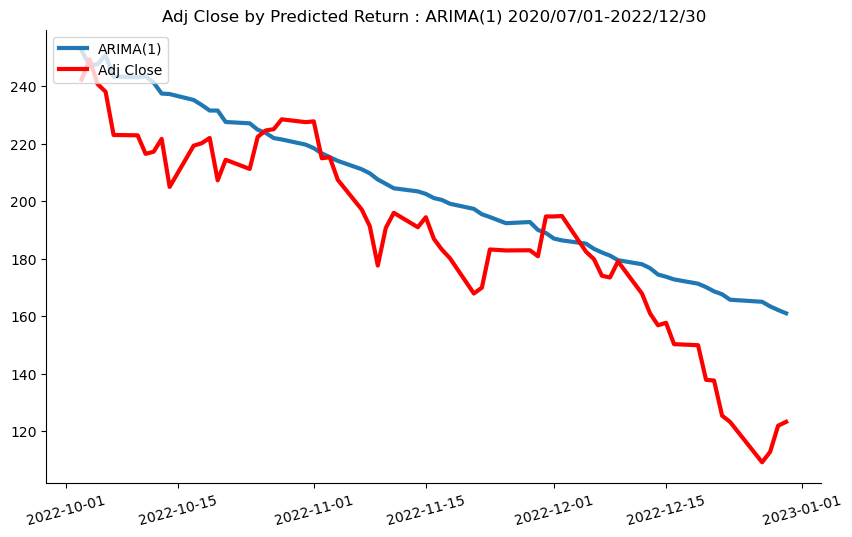

In [528]:
first_price=tsla_data_o["Adj Close"][-VAR_nobs-1]
fig,ax = plt.subplots(figsize=(10,6),dpi=100)
ARIMA_result_rsp=first_price*np.exp(np.array(ARIMA_result_best)*0.01)
ax.spines[['top','right']].set_visible(False)
plt.plot(tsla_data_o.index[-VAR_nobs:],ARIMA_result_rsp, label='ARIMA(1)', linewidth=3)

plt.plot(tsla_data_o["Adj Close"][-VAR_nobs:], label = 'Adj Close',color="red", linewidth=3)
plt.legend(loc='upper left')
plt.title("Adj Close by Predicted Return : ARIMA(1) 2020/07/01-2022/12/30")
plt.xticks(rotation=15)


print('Forecast Accuracy of: Adj Close with Score')
accuracy_prod = forecast_accuracy(ARIMA_result_rsp, tsla_data_o["Adj Close"][-VAR_nobs:])
for k, v in accuracy_prod.items():
    print(round(v,4))

In [529]:


import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

[Text(0.5, 0, 'Negative Score'),
 Text(1.5, 0, 'Neutral Score'),
 Text(2.5, 0, 'Positive Score'),
 Text(3.5, 0, 'Compound Score'),
 Text(4.5, 0, 'count'),
 Text(5.5, 0, 'Adj Close'),
 Text(6.5, 0, 'Return')]

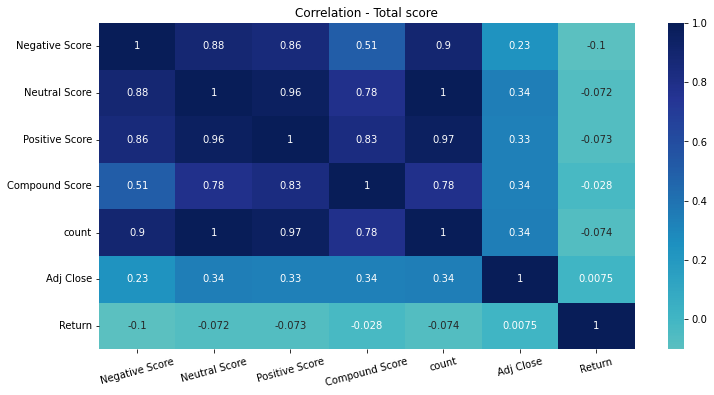

In [530]:
Numerical_Columns=['Negative Score','Neutral Score','Positive Score','Compound Score','count','Adj Close', 'Return']
plt.figure(figsize=(12, 6))
plt.title('Correlation - Total score')
ax = sns.heatmap(tsla_data_cs[Numerical_Columns].corr(), annot = True, center=0, cmap="YlGnBu")
# 將xlabel轉正
ax.set_xticklabels(ax.get_xticklabels(), rotation=15)

## 用Adj Close做LR

In [531]:
variable=["Neutral Score","Compound Score"]
x_train=interval_train[variable]
x_test=interval_test[variable]
y_train=interval_train[["Adj Close"]]
y_test=interval_test[["Adj Close"]]

In [532]:
#Scaling the train data for LinearRegression
scaler = MinMaxScaler()
Cols=x_train.columns
x_train_scaled=scaler.fit_transform(x_train)
x_train_scaled=pd.DataFrame(x_train_scaled,columns=Cols)
x_test_scaled=scaler.fit_transform(x_test)
x_test_scaled=pd.DataFrame(x_test_scaled,columns=Cols)
x_train_scaled

,Neutral Score,Compound Score
0,0.106033,0.264095
1,0.300599,0.450334
2,0.087612,0.266029
3,0.512894,0.501317
4,0.000000,0.172667
...,...,...
563,0.000000,0.172667
564,0.202625,0.094063
565,0.295188,0.450409
566,0.195602,0.358280


In [533]:
#Building baseline LinearRegression model
ModelLR=LR()
ModelLR.fit(x_train_scaled, y_train)
preds_val = ModelLR.predict(x_test_scaled)
np.sqrt(mean_squared_error(y_test, preds_val))

0.2545407419401782

Forecast Accuracy of: Adj Close with Score
0.2361
31.075
37.2106
0.2096
47.5088
0.1104
0.1659


/var/folders/2x/hsg4y6rn0jv457jmxcnf6s7r0000gp/T/ipykernel_6918/401182582.py:51: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
/var/folders/2x/hsg4y6rn0jv457jmxcnf6s7r0000gp/T/ipykernel_6918/401182582.py:53: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


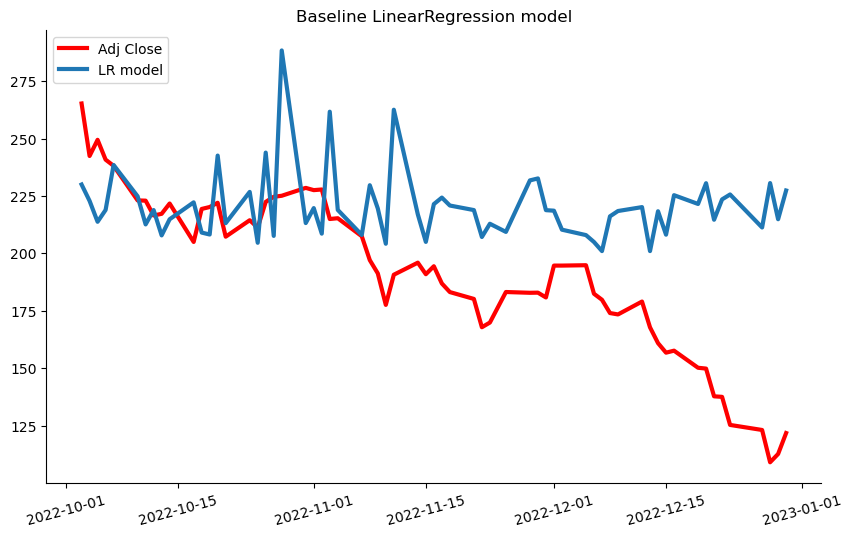

In [534]:
#Plotting the predicted values from baseline LinearRegression model
fp=tsla_data_o["Adj Close"][-VAR_nobs-1]
actual_price=np.exp(np.array(interval_test["Adj Close"]))
pred_adj=np.exp(preds_val)
pred_adj=np.array([ i[0] for i in pred_adj])
fig,ax = plt.subplots(figsize=(10,6),dpi=100)
#plt.plot(interval.index[:],np.exp(np.array(interval['Adj Close'])), 'green', color='blue', label='Training Data')
plt.plot(interval_test.index,actual_price, color='red', label='Adj Close',linewidth=3)
plt.plot(x_test.index, pred_adj, label='LR model',linewidth=3)
plt.title('Baseline LinearRegression model')
ax.spines[['top','right']].set_visible(False)
plt.xticks(rotation=15)
plt.legend(loc='upper left')
#arima模型精確度
print('Forecast Accuracy of: Adj Close with Score')
accuracy_prod = forecast_accuracy(pred_adj,tsla_data_o["Adj Close"][-VAR_nobs:])
for k, v in accuracy_prod.items():
    print(round(v,4))

## Baseline DecisionTreeRegressor model

In [535]:
#Building a baseline DecisionTreeRegressor model
ModelDTR=DTR()
ModelDTR.fit(x_train, y_train)
preds_val = ModelLR.predict(x_test)
np.sqrt(mean_squared_error(y_test, preds_val))

1.327148181735543

In [536]:
#Searching for best DecisionTreeRegressor model parameters using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
param_grid = {"criterion": ["mse", "mae"],
              "min_samples_split": [2, 10, 20, 30, 40],
              "max_depth": [4, 6, 8, 10, 12],
              "min_samples_leaf": [8, 16, 32, 64, 128],
              "max_leaf_nodes": [8, 16, 32, 64, 128],
              }
preds_val = RandomizedSearchCV(DTR(),
                         param_grid,
                         scoring='neg_mean_squared_error',
                         n_iter=90)

search = preds_val.fit(x_train, y_train)

search.best_params_

/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:

/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes

/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:

/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py

/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py

/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py

/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:

/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes

/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes

/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes

{'min_samples_split': 40,
 'min_samples_leaf': 128,
 'max_leaf_nodes': 128,
 'max_depth': 10,
 'criterion': 'mae'}

In [537]:
#Constructing the optimal DecisionTreeRegressor model
optimal_params = {'min_samples_split': 30,
 'min_samples_leaf': 8,
 'max_leaf_nodes': 16,
 'max_depth': 12,
 'criterion': 'mse'}
ModelDTRBest=DTR(**optimal_params)
ModelDTRBest.fit(x_train, y_train)
preds_val = ModelDTRBest.predict(x_test)
np.sqrt(mean_squared_error(y_test, preds_val))

/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(


0.3174943026637554

/var/folders/2x/hsg4y6rn0jv457jmxcnf6s7r0000gp/T/ipykernel_6918/401182582.py:51: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
/var/folders/2x/hsg4y6rn0jv457jmxcnf6s7r0000gp/T/ipykernel_6918/401182582.py:53: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


Forecast Accuracy of: Adj Close with Score
0.3229
46.958
52.7673
0.2972
64.0988
0.0599
0.2149


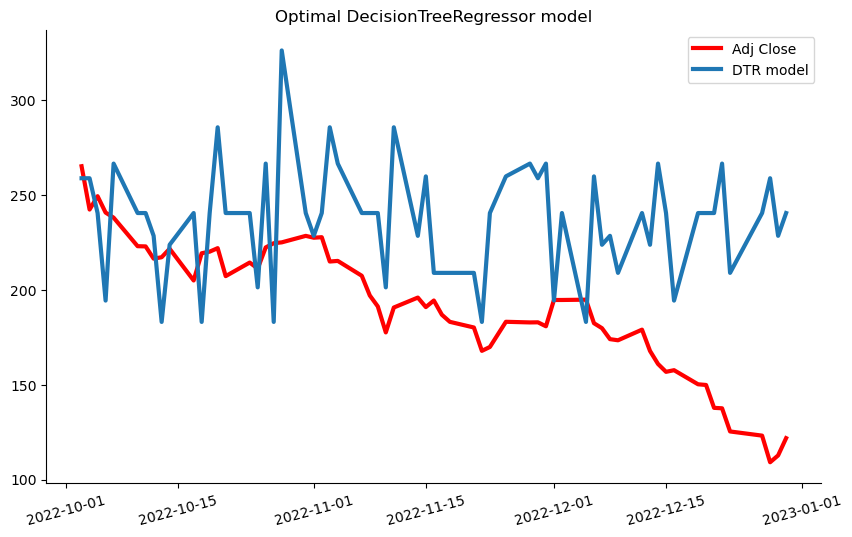

In [538]:
#Plotting the Optimal DecisionTreeRegressor model

fp=tsla_data_o["Adj Close"][-VAR_nobs-1]
actual_price=np.exp(np.array(interval_test["Adj Close"]))
pred_adj=np.exp(preds_val)

fig,ax = plt.subplots(figsize=(10,6),dpi=100)
#plt.plot(interval.index[:],np.exp(np.array(interval['Adj Close'])), 'green', color='blue', label='Training Data')
plt.plot(interval_test.index,actual_price, color='red', label='Adj Close',linewidth=3)
plt.plot(x_test.index, pred_adj, label='DTR model',linewidth=3)
plt.title('Optimal DecisionTreeRegressor model')
ax.spines[['top','right']].set_visible(False)
plt.xticks(rotation=15)
plt.legend(loc='upper right')
#arima模型精確度
print('Forecast Accuracy of: Adj Close with Score')
accuracy_prod = forecast_accuracy(pred_adj,tsla_data_o["Adj Close"][-VAR_nobs:])
for k, v in accuracy_prod.items():
    print(round(v,4))

## Hybrid Model

In [539]:

Hybrid_Prediction=pd.DataFrame(tsla_data_o["Adj Close"][-VAR_nobs:])
Hybrid_Prediction=Hybrid_Prediction.set_index(y_test.index)
DTP_df=pd.DataFrame(np.exp(np.array(preds_val)),index=y_test.index,columns=["DTPrediction"])
ARIMA_Prediction=pd.DataFrame(np.exp(interval_train["Adj Close"][-1])*np.exp(np.array(ARIMA_result_best)*0.01),index=y_test.index,columns=["ARIMA_Prediction"])
Hybrid_Prediction=Hybrid_Prediction.join(DTP_df)
Hybrid_Prediction=Hybrid_Prediction.join(ARIMA_Prediction)
Hybrid_Prediction

,Adj Close,DTPrediction,ARIMA_Prediction
Date,,,
2022-10-03,242.399994,258.911805,255.328807
2022-10-04,249.440002,258.911805,249.996452
2022-10-05,240.809998,240.561116,250.517554
2022-10-06,238.130005,194.385670,253.636075
2022-10-07,223.070007,266.645241,246.122809
...,...,...,...
2022-12-23,123.150002,208.996341,167.549443
2022-12-27,109.099998,240.561116,166.824731
2022-12-28,112.709999,258.911805,165.210584


In [540]:
def FinalPrediction(ratio,Hybrid_Prediction):
    PredFinal=ratio*Hybrid_Prediction['ARIMA_Prediction']+(1-ratio)*Hybrid_Prediction['DTPrediction']
    return PredFinal

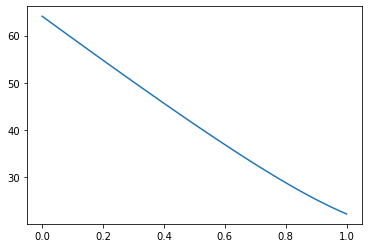

1.0


In [545]:
ratio_list=np.arange(0,1.01,0.01)
r_list=[]
for ratio in ratio_list:
    PredFinal=FinalPrediction(ratio,Hybrid_Prediction)
    r_list.append(np.sqrt(mean_squared_error(Hybrid_Prediction['Adj Close'],PredFinal)))
plt.plot(ratio_list,r_list)
plt.show()
min_ratio=ratio_list[r_list.index(min(r_list))]
print(min_ratio)

In [546]:
#Implenting Final Hybrid model
PredFinal=FinalPrediction(min_ratio,Hybrid_Prediction)
print(np.sqrt(mean_squared_error(Hybrid_Prediction['Adj Close'],PredFinal)))

22.261061981185165


In [547]:
#Final Hybrid model mean absolute error
print(mean_absolute_error(Hybrid_Prediction['Adj Close'],PredFinal))

18.112555728790163


Forecast Accuracy of: Adj Close with Score
0.1113
17.0612
18.1126
0.1063
22.2611
0.9194
0.0927


/var/folders/2x/hsg4y6rn0jv457jmxcnf6s7r0000gp/T/ipykernel_6918/401182582.py:50: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:,None],
/var/folders/2x/hsg4y6rn0jv457jmxcnf6s7r0000gp/T/ipykernel_6918/401182582.py:51: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
/var/folders/2x/hsg4y6rn0jv457jmxcnf6s7r0000gp/T/ipykernel_6918/401182582.py:52: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:,None],
/var/folders/2x/hsg4y6rn0jv457jmxcnf6s7r0000gp/T/ipykernel_6918/401182582.py:53: FutureWarn

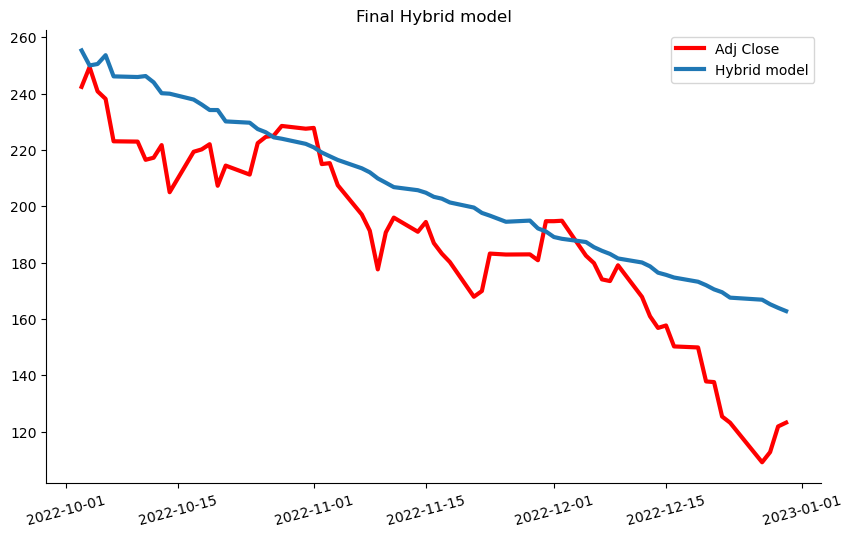

In [548]:

fp=tsla_data_o["Adj Close"][-VAR_nobs:][0]
pred_adj=np.exp(fp)*np.exp(preds_val*0.01)

fig,ax = plt.subplots(figsize=(10,6),dpi=100)
#plt.plot(interval.index[:],np.exp(np.array(interval['Adj Close'])), 'green', color='blue', label='Training Data')
plt.plot(Hybrid_Prediction[["Adj Close"]], color='red', label='Adj Close',linewidth=3)
plt.plot(Hybrid_Prediction.index, PredFinal, label='Hybrid model',linewidth=3)
plt.title('Final Hybrid model')
ax.spines[['top','right']].set_visible(False)
plt.xticks(rotation=15)
plt.legend(loc='upper right')
#arima模型精確度
print('Forecast Accuracy of: Adj Close with Score')
accuracy_prod = forecast_accuracy(PredFinal,tsla_data_o["Adj Close"][-VAR_nobs:])
for k, v in accuracy_prod.items():
    print(round(v,4))